# **Classification task to fine-tune personal documents**

## **Mount Google Drive**

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


##**Importing all libraries we need**




In [ ]:
%%capture

!pip install codecarbon
!pip install mxnet
!pip install vit-keras
!pip install tensorflow-addons==0.16.1

In [ ]:
import os
import sklearn
import random
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import random

from tqdm.notebook import tqdm
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from codecarbon import EmissionsTracker
import itertools

from tensorflow.keras.utils import load_img
from keras.models import load_model
from tensorflow.keras.utils import img_to_array
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.utils import Sequence as Sequence
from tensorflow.keras.preprocessing.image import random_rotation

from tensorflow.keras import models
from tensorflow.keras import optimizers
from tensorflow.keras import layers, Sequential
from tensorflow.keras.applications.vgg16 import preprocess_input as preproc_vgg
from tensorflow.keras.applications import MobileNetV3Large
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import LeakyReLU
import mxnet as mx
from keras.models import load_model
from enum import Enum
from tensorflow.keras.models import Model


from IPython.display import Image, display
from tensorflow.keras.preprocessing import image
import matplotlib.cm as c_map


##**Constants values**

In [ ]:
## File images path
base_path = "MY_PATH"
base_path_img = "MY_PATH"

## Data Generator values
batch_size = 16
inp_dim = (224,224)
n_channels = 3
n_classes = 10

## Image files list
imgs_list = os.listdir(base_path_img)

## Image size
input_size = (224, 224, 3)

## Training, Validation and Testing Percent
train_perc = 0.7
valid_perc = 0.1

## Epoch numbers for fine tuning
num_epochs = 30

## plotlib results number
num_results = 20


##**Switch case classes**

In [ ]:
## Define different classes to create each label

img_ids = ["ic_CIE.front.", "ic_CIE.rear.", "dl_I11.front.", "dl_I11.rear.", "dl_I10.front.", "dl_I10.rear.", "ic_TES.front.", "ic_TES.rear.", "doc_NR.front.", "doc_NR.rear."]

def switch(img_id):
    for i, id in enumerate(img_ids):
        if id in img_id:
            return i
    return None

## **Data Augmentation**

In [ ]:
#Augment data randomly throw rotation, brightless and lighting

def switch_aug(img_):
  temp_img = img_.copy()
  rndm_value = random.uniform(0.2, 0.6)
  rndm_type = random.randint(0, 2)
  if rndm_type == 0:
    alpha = np.random.normal(0, 100, size=(3,))
    rgb = np.dot(np.asarray([1,1,1]) * alpha, np.ones((3,3)))
    img_ = temp_img + rgb
  elif rndm_type == 1:
    aug = mx.image.BrightnessJitterAug(brightness=rndm_value)
    img_ = aug(temp_img)
  elif rndm_type == 2:
    img_ = random_rotation(img_, rg=30, row_axis=0, col_axis=1, channel_axis=2, fill_mode='constant')
  return img_

def augment_data(img_):
  img_ = switch_aug(img_)
  img_ = random_rotation(img_, rg=30, row_axis=0, col_axis=1, channel_axis=2, fill_mode='constant')
  return img_

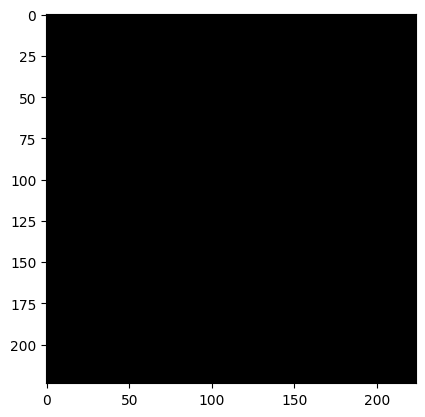

In [ ]:
#Sample

image_path = os.path.join(base_path_img,"dl_I10.front.6397.jpg")
img = load_img(image_path, target_size = inp_dim)
img = img_to_array(img)

img = preproc_vgg(img)
img = augment_data(img)
img = np.clip(img, 0, 1)
plt.imshow(img)
plt.show()

## **Data Generator**

In [ ]:
## Generates data for Keras

class DataGenerator(Sequence):
    def __init__(
        self, all_imgs_list, split_A, split_B, batch_size=batch_size, n_channels=n_channels,
        n_classes=n_classes, inp_dim=inp_dim, train=False, shuffle=False):

        ## Initialization of attributes
        self.list_IDs = all_imgs_list
        self.batch_size = batch_size
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.inp_dim = inp_dim
        self.shuffle = shuffle
        self.train = train

        ## Get number of all the images contained in the directory

        self.len = len(self.list_IDs)

        ## Split into training, validation or test set
        self.list_IDs = self.list_IDs[int(self.len*split_A):int(self.len*split_B)]
        self.on_epoch_end()

    ## Denotes the number of batches per epoch

    def __len__(self):
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    ## get_item generates one batch of data

    def __getitem__(self, index):
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        ## Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        ## Generate data
        X, y = self.__data_generation(list_IDs_temp)

        return X, y

    ## Updates indexes after each epoch

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle or self.train:
            np.random.shuffle(self.indexes)


    ## Generates data containing batch_size samples

    def __data_generation(self, list_IDs_temp):
        ## Initialization with empty tensors
        X = np.empty((self.batch_size, *self.inp_dim, self.n_channels))
        y = np.empty((self.batch_size), dtype=int)

        # Generate data: for i in batch_size fill the input and label vectors
        for i, (ID, augmented) in enumerate(list_IDs_temp):
          ## Get image
          img = load_img(ID, target_size = self.inp_dim)
          img = img_to_array(img)
          img = preproc_vgg(img)

          current_index_class = switch(ID)
          if self.train:
            if augmented:
                img = augment_data(img)

          ## Store images
          X[i, ] = img

          ## Store classes
          y[i] = current_index_class

        # Converts our classes in one hot encoded vector.
        y = tf.keras.utils.to_categorical(y, num_classes=self.n_classes)
        return X, y

In [ ]:
## shuffle datas
random.shuffle(imgs_list)
imgs_list = [os.path.join(base_path_img, img) for img in imgs_list]

## create empty tuple list
imgs_list_aug = []

## create dict with img_class index and all images of that class
balanced_img = {switch(i): [] for i in img_ids}
for j in imgs_list:
  h = switch(j)
  balanced_img[h].append((j, False))

#find the largest class
max_len = max([len(i) for i in balanced_img.values()])

## recreate balanced_img with same dimension
for img_class, img_list_data in balanced_img.items():
  for h in range((max_len + 1) - len(img_list_data)):
    my_list = random.sample(img_list_data,1)
    balanced_img[img_class].append((my_list[0][0], True))

## reduce balanced_img to list
for i in balanced_img.values():
  for j in i:
    imgs_list_aug.append(j)

random.shuffle(imgs_list_aug)

In [ ]:
#Sample to check shuffle is ok


train_gen_number = int((len(imgs_list_aug) * train_perc))
train_data = imgs_list_aug[:train_gen_number]

valid_gen_number = int(len(imgs_list_aug) * (train_perc + valid_perc))
valid_data = imgs_list_aug[len(train_data):valid_gen_number]

test_gen_number = int(len(imgs_list_aug))
test_data = imgs_list_aug[len(train_data + valid_data):test_gen_number]



tot = [(train_data, "train_data"), (valid_data, "valid_data"), (test_data, "test_data")]
for i,name in enumerate(tot):
  ic_CIE_front = []
  ic_CIE_rear = []
  dl_I11_front = []
  dl_I11_rear = []
  dl_I10_front = []
  dl_I10_rear = []
  ic_TES_front = []
  ic_TES_rear = []
  doc_NR_front = []
  doc_NR_rear = []
  for elem in name[0]:
    path = str(elem[0])
    if img_ids[0] in path : ic_CIE_front.append(path)
    elif img_ids[1] in path : ic_CIE_rear.append(path)
    elif img_ids[2] in path : dl_I11_front.append(path)
    elif img_ids[3] in path : dl_I11_rear.append(path)
    elif img_ids[4] in path : dl_I10_front.append(path)
    elif img_ids[5] in path : dl_I10_rear.append(path)
    elif img_ids[6] in path : ic_TES_front.append(path)
    elif img_ids[7] in path : ic_TES_rear.append(path)
    elif img_ids[8] in path : doc_NR_front.append(path)
    elif img_ids[9] in path : doc_NR_rear.append(path)

  print("\n La classe ic_CIE_front ha elementi in " + str(name[1]) + ": " + str(len(ic_CIE_front)),"\n",
      "La classe ic_CIE_rear ha elementi in " + str(name[1]) + ": " + str(len(ic_CIE_rear)),"\n",
      "La classe dl_I11_front ha elementi in " + str(name[1]) + ": " + str(len(dl_I11_front)),"\n",
      "La classe dl_I11_rear ha elementi in " + str(name[1]) + ": " + str(len(dl_I11_rear)),"\n",
      "La classe dl_I10_front ha elementi in " + str(name[1]) + ": " + str(len(dl_I10_front)),"\n",
      "La classe dl_I10_rear ha elementi in " + str(name[1]) + ": " + str(len(dl_I10_rear)),"\n",
      "La classe ic_TES_front ha elementi in " + str(name[1]) + ": " + str(len(ic_TES_front)),"\n",
      "La classe ic_TES_rear ha elementi in " + str(name[1]) + ": " + str(len(ic_TES_rear)),"\n",
      "La classe doc_NR_front ha elementi in " + str(name[1]) + ": " + str(len(doc_NR_front)),"\n",
      "La classe doc_NR_rear ha elementi in " + str(name[1]) + ": " + str(len(doc_NR_rear)),"\n")


 La classe ic_CIE_front ha elementi in train_data: 64 
 La classe ic_CIE_rear ha elementi in train_data: 67 
 La classe dl_I11_front ha elementi in train_data: 69 
 La classe dl_I11_rear ha elementi in train_data: 72 
 La classe dl_I10_front ha elementi in train_data: 66 
 La classe dl_I10_rear ha elementi in train_data: 63 
 La classe ic_TES_front ha elementi in train_data: 63 
 La classe ic_TES_rear ha elementi in train_data: 72 
 La classe doc_NR_front ha elementi in train_data: 71 
 La classe doc_NR_rear ha elementi in train_data: 65 


 La classe ic_CIE_front ha elementi in valid_data: 8 
 La classe ic_CIE_rear ha elementi in valid_data: 6 
 La classe dl_I11_front ha elementi in valid_data: 6 
 La classe dl_I11_rear ha elementi in valid_data: 5 
 La classe dl_I10_front ha elementi in valid_data: 13 
 La classe dl_I10_rear ha elementi in valid_data: 13 
 La classe ic_TES_front ha elementi in valid_data: 12 
 La classe ic_TES_rear ha elementi in valid_data: 8 
 La classe doc_NR_fro

In [ ]:
#Create generators

train_generator = DataGenerator(imgs_list_aug, 0, train_perc, train=True, shuffle=True)
valid_generator = DataGenerator(imgs_list_aug, train_perc, train_perc + valid_perc)
test_generator  = DataGenerator(imgs_list_aug, train_perc + valid_perc, 1)

In [ ]:
#Print generator values
print("Numero di immagini nel generator di addestramento:", len(train_generator) * train_generator.batch_size)
print("Numero di immagini nel generator di validazione:", len(valid_generator) * valid_generator.batch_size)
print("Numero di immagini nel generator di test:", len(test_generator) * test_generator.batch_size)

Numero di immagini nel generator di addestramento: 672
Numero di immagini nel generator di validazione: 80
Numero di immagini nel generator di test: 192


## **Define model**

In [ ]:
# Define model

vgg16 = VGG16(input_shape=(input_size[0], input_size[1], input_size[2]), include_top=True, weights='imagenet')

553467096/553467096 [==============================] - 7s 0us/step


In [ ]:
vgg16.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
# Function to freeze model, except last layers

def gen_models(modelInput):
  for layer in modelInput.layers:
      layer.trainable = False
  new_model = modelInput.layers[-3].output
  fc1_bis = tf.keras.layers.Dense(2048, activation='relu', name = "fc1_bis")(new_model)
  fc2 = tf.keras.layers.Dense(1024, activation='relu', name = "fc2")(fc1_bis)
  fc3 = tf.keras.layers.Dense(512, activation='relu', name = "fc3")(fc2)
  softmax = tf.keras.layers.Dense(n_classes, activation='softmax', name = "softmax")(fc3)
  model = tf.keras.models.Model(inputs=modelInput.input, outputs=softmax)
  return model


In [ ]:
# Create our custom model

model = gen_models(vgg16)

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

# **Classification**

In [ ]:
## TODO DEFINIRE GLI IPERPARAMETRI SOPRA

momentum = 0.9
learning_rates = 0.0001

my_optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rates, momentum=momentum)

In [ ]:
## Create a directory where the model weights will be saved
path_ = base_path

if not os.path.exists (os.path.join(path_, "vgg16_results_")):
  os.mkdir(os.path.join(path_, "vgg16_results_"))
res_dir = os.path.join(path_, "vgg16_results_")

In [ ]:
## Start training our custom model

model.compile(loss="categorical_crossentropy", metrics=["accuracy"],
              optimizer=my_optimizer)


es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)

checkpoint = ModelCheckpoint(os.path.join(res_dir, "model.h5"),
                             verbose=1, monitor='val_loss', save_best_only=True)

tracker = EmissionsTracker()
tracker.start()

history = model.fit(train_generator, validation_data=valid_generator,
                  epochs=num_epochs, batch_size=batch_size, verbose=1, callbacks=[checkpoint, es])

emissions: float = tracker.stop()

[codecarbon INFO @ 12:39:48] [setup] RAM Tracking...
[codecarbon INFO @ 12:39:48] [setup] GPU Tracking...
[codecarbon INFO @ 12:39:48] Tracking Nvidia GPU via pynvml
[codecarbon INFO @ 12:39:48] [setup] CPU Tracking...
[codecarbon WARNING @ 12:39:48] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon WARNING @ 12:39:51] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon INFO @ 12:39:51] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 12:39:51] >>> Tracker's metadata:
[codecarbon INFO @ 12:39:51]   Platform system: Linux-5.15.109+-x86_64-with-glibc2.31
[codecarbon INFO @ 12:39:51]   Python version: 3.10.12
[codecarbon INFO @ 12:39:51]   CodeCarbon version: 2.2.5
[codecarbon INFO @ 12:39:51]   Available RAM : 12.678 GB
[codecarbon INFO @ 12:39:51]   CPU count: 2
[codecarbon INFO @ 12:39:51]   CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 12:39:51]   GPU

Epoch 1/30


[codecarbon INFO @ 12:40:06] Energy consumed for RAM : 0.000020 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 12:40:06] Energy consumed for all GPUs : 0.000115 kWh. Total GPU Power : 27.541 W
[codecarbon INFO @ 12:40:06] Energy consumed for all CPUs : 0.000178 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 12:40:06] 0.000313 kWh of electricity used since the beginning.


 4/42 [=>............................] - ETA: 24s - loss: 3.3332 - accuracy: 0.1094

[codecarbon INFO @ 12:40:21] Energy consumed for RAM : 0.000040 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 12:40:21] Energy consumed for all GPUs : 0.000231 kWh. Total GPU Power : 27.935000000000002 W
[codecarbon INFO @ 12:40:21] Energy consumed for all CPUs : 0.000354 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 12:40:21] 0.000625 kWh of electricity used since the beginning.


20/42 [=============>................] - ETA: 19s - loss: 2.7589 - accuracy: 0.2156

[codecarbon INFO @ 12:40:36] Energy consumed for RAM : 0.000059 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 12:40:36] Energy consumed for all GPUs : 0.000348 kWh. Total GPU Power : 28.132 W
[codecarbon INFO @ 12:40:36] Energy consumed for all CPUs : 0.000531 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 12:40:36] 0.000939 kWh of electricity used since the beginning.


36/42 [========================>.....] - ETA: 5s - loss: 2.0599 - accuracy: 0.4010

[codecarbon INFO @ 12:40:51] Energy consumed for RAM : 0.000079 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 12:40:51] Energy consumed for all GPUs : 0.000465 kWh. Total GPU Power : 28.132 W
[codecarbon INFO @ 12:40:51] Energy consumed for all CPUs : 0.000709 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 12:40:51] 0.001253 kWh of electricity used since the beginning.


42/42 [==============================] - ETA: 0s - loss: 1.8504 - accuracy: 0.4613
Epoch 1: val_loss improved from inf to 0.71617, saving model to /content/gdrive/MyDrive/TestCV&DL/vgg16_results_/model.h5


[codecarbon INFO @ 12:41:07] Energy consumed for RAM : 0.000100 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 12:41:07] Energy consumed for all GPUs : 0.000589 kWh. Total GPU Power : 28.329 W
[codecarbon INFO @ 12:41:07] Energy consumed for all CPUs : 0.000894 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 12:41:07] 0.001583 kWh of electricity used since the beginning.


42/42 [==============================] - 67s 1s/step - loss: 1.8504 - accuracy: 0.4613 - val_loss: 0.7162 - val_accuracy: 0.8000
Epoch 2/30
10/42 [======>.......................] - ETA: 29s - loss: 0.4986 - accuracy: 0.8750

[codecarbon INFO @ 12:41:22] Energy consumed for RAM : 0.000120 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 12:41:22] Energy consumed for all GPUs : 0.000707 kWh. Total GPU Power : 28.427 W
[codecarbon INFO @ 12:41:22] Energy consumed for all CPUs : 0.001071 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 12:41:22] 0.001898 kWh of electricity used since the beginning.


25/42 [================>.............] - ETA: 16s - loss: 0.4184 - accuracy: 0.8900

[codecarbon INFO @ 12:41:37] Energy consumed for RAM : 0.000139 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 12:41:37] Energy consumed for all GPUs : 0.000827 kWh. Total GPU Power : 28.722 W
[codecarbon INFO @ 12:41:37] Energy consumed for all CPUs : 0.001249 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 12:41:37] 0.002215 kWh of electricity used since the beginning.


38/42 [==========================>...] - ETA: 4s - loss: 0.3698 - accuracy: 0.9079

[codecarbon INFO @ 12:41:52] Energy consumed for RAM : 0.000159 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 12:41:52] Energy consumed for all GPUs : 0.000947 kWh. Total GPU Power : 28.919 W
[codecarbon INFO @ 12:41:52] Energy consumed for all CPUs : 0.001426 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 12:41:52] 0.002532 kWh of electricity used since the beginning.


42/42 [==============================] - ETA: 0s - loss: 0.3632 - accuracy: 0.9107
Epoch 2: val_loss improved from 0.71617 to 0.36250, saving model to /content/gdrive/MyDrive/TestCV&DL/vgg16_results_/model.h5
42/42 [==============================] - 55s 1s/step - loss: 0.3632 - accuracy: 0.9107 - val_loss: 0.3625 - val_accuracy: 0.8875


[codecarbon INFO @ 12:42:07] Energy consumed for RAM : 0.000179 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 12:42:07] Energy consumed for all GPUs : 0.001067 kWh. Total GPU Power : 28.919 W
[codecarbon INFO @ 12:42:07] Energy consumed for all CPUs : 0.001603 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 12:42:07] 0.002849 kWh of electricity used since the beginning.
[codecarbon INFO @ 12:42:22] Energy consumed for RAM : 0.000199 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 12:42:22] Energy consumed for all GPUs : 0.001188 kWh. Total GPU Power : 28.919 W
[codecarbon INFO @ 12:42:22] Energy consumed for all CPUs : 0.001780 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 12:42:22] 0.003166 kWh of electricity used since the beginning.


Epoch 3/30
 4/42 [=>............................] - ETA: 33s - loss: 0.1632 - accuracy: 0.9844

[codecarbon INFO @ 12:42:37] Energy consumed for RAM : 0.000219 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 12:42:37] Energy consumed for all GPUs : 0.001309 kWh. Total GPU Power : 29.1 W
[codecarbon INFO @ 12:42:37] Energy consumed for all CPUs : 0.001957 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 12:42:37] 0.003484 kWh of electricity used since the beginning.


20/42 [=============>................] - ETA: 20s - loss: 0.2208 - accuracy: 0.9531

[codecarbon INFO @ 12:42:52] Energy consumed for RAM : 0.000238 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 12:42:52] Energy consumed for all GPUs : 0.001431 kWh. Total GPU Power : 29.215 W
[codecarbon INFO @ 12:42:52] Energy consumed for all CPUs : 0.002134 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 12:42:52] 0.003803 kWh of electricity used since the beginning.


36/42 [========================>.....] - ETA: 5s - loss: 0.1981 - accuracy: 0.9635

[codecarbon INFO @ 12:43:07] Energy consumed for RAM : 0.000258 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 12:43:07] Energy consumed for all GPUs : 0.001681 kWh. Total GPU Power : 60.096000000000004 W
[codecarbon INFO @ 12:43:07] Energy consumed for all CPUs : 0.002311 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 12:43:07] 0.004250 kWh of electricity used since the beginning.


42/42 [==============================] - ETA: 0s - loss: 0.1957 - accuracy: 0.9673
Epoch 3: val_loss improved from 0.36250 to 0.27245, saving model to /content/gdrive/MyDrive/TestCV&DL/vgg16_results_/model.h5


[codecarbon INFO @ 12:43:22] Energy consumed for RAM : 0.000278 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 12:43:22] Energy consumed for all GPUs : 0.001803 kWh. Total GPU Power : 29.494 W
[codecarbon INFO @ 12:43:22] Energy consumed for all CPUs : 0.002488 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 12:43:22] 0.004569 kWh of electricity used since the beginning.


42/42 [==============================] - 52s 1s/step - loss: 0.1957 - accuracy: 0.9673 - val_loss: 0.2724 - val_accuracy: 0.9125


[codecarbon INFO @ 12:43:37] Energy consumed for RAM : 0.000298 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 12:43:37] Energy consumed for all GPUs : 0.001926 kWh. Total GPU Power : 29.494 W
[codecarbon INFO @ 12:43:37] Energy consumed for all CPUs : 0.002665 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 12:43:37] 0.004889 kWh of electricity used since the beginning.
[codecarbon INFO @ 12:43:52] Energy consumed for RAM : 0.000317 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 12:43:52] Energy consumed for all GPUs : 0.002049 kWh. Total GPU Power : 29.592000000000002 W
[codecarbon INFO @ 12:43:52] Energy consumed for all CPUs : 0.002842 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 12:43:52] 0.005209 kWh of electricity used since the beginning.


Epoch 4/30
12/42 [=======>......................] - ETA: 28s - loss: 0.1206 - accuracy: 0.9896

[codecarbon INFO @ 12:44:07] Energy consumed for RAM : 0.000337 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 12:44:07] Energy consumed for all GPUs : 0.002173 kWh. Total GPU Power : 29.789 W
[codecarbon INFO @ 12:44:07] Energy consumed for all CPUs : 0.003019 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 12:44:07] 0.005530 kWh of electricity used since the beginning.


28/42 [===================>..........] - ETA: 13s - loss: 0.1218 - accuracy: 0.9911

[codecarbon INFO @ 12:44:22] Energy consumed for RAM : 0.000357 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 12:44:22] Energy consumed for all GPUs : 0.002298 kWh. Total GPU Power : 29.986 W
[codecarbon INFO @ 12:44:22] Energy consumed for all CPUs : 0.003196 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 12:44:22] 0.005851 kWh of electricity used since the beginning.


42/42 [==============================] - ETA: 0s - loss: 0.1138 - accuracy: 0.9926

[codecarbon INFO @ 12:44:37] Energy consumed for RAM : 0.000377 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 12:44:37] Energy consumed for all GPUs : 0.002423 kWh. Total GPU Power : 30.084 W
[codecarbon INFO @ 12:44:37] Energy consumed for all CPUs : 0.003373 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 12:44:37] 0.006173 kWh of electricity used since the beginning.



Epoch 4: val_loss improved from 0.27245 to 0.21280, saving model to /content/gdrive/MyDrive/TestCV&DL/vgg16_results_/model.h5
42/42 [==============================] - 52s 1s/step - loss: 0.1138 - accuracy: 0.9926 - val_loss: 0.2128 - val_accuracy: 0.9250
Epoch 5/30
 4/42 [=>............................] - ETA: 43s - loss: 0.0947 - accuracy: 0.9844

[codecarbon INFO @ 12:44:52] Energy consumed for RAM : 0.000397 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 12:44:52] Energy consumed for all GPUs : 0.002549 kWh. Total GPU Power : 30.183 W
[codecarbon INFO @ 12:44:52] Energy consumed for all CPUs : 0.003550 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 12:44:52] 0.006496 kWh of electricity used since the beginning.


19/42 [============>.................] - ETA: 23s - loss: 0.1060 - accuracy: 0.9901

[codecarbon INFO @ 12:45:07] Energy consumed for RAM : 0.000416 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 12:45:07] Energy consumed for all GPUs : 0.002800 kWh. Total GPU Power : 60.291000000000004 W
[codecarbon INFO @ 12:45:07] Energy consumed for all CPUs : 0.003727 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 12:45:07] 0.006943 kWh of electricity used since the beginning.


35/42 [========================>.....] - ETA: 6s - loss: 0.0979 - accuracy: 0.9893

[codecarbon INFO @ 12:45:22] Energy consumed for RAM : 0.000436 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 12:45:22] Energy consumed for all GPUs : 0.003032 kWh. Total GPU Power : 55.732000000000006 W
[codecarbon INFO @ 12:45:22] Energy consumed for all CPUs : 0.003904 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 12:45:22] 0.007372 kWh of electricity used since the beginning.


42/42 [==============================] - ETA: 0s - loss: 0.0902 - accuracy: 0.9911
Epoch 5: val_loss improved from 0.21280 to 0.19078, saving model to /content/gdrive/MyDrive/TestCV&DL/vgg16_results_/model.h5


[codecarbon INFO @ 12:45:37] Energy consumed for RAM : 0.000456 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 12:45:37] Energy consumed for all GPUs : 0.003159 kWh. Total GPU Power : 30.478 W
[codecarbon INFO @ 12:45:37] Energy consumed for all CPUs : 0.004081 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 12:45:37] 0.007696 kWh of electricity used since the beginning.


42/42 [==============================] - 51s 1s/step - loss: 0.0902 - accuracy: 0.9911 - val_loss: 0.1908 - val_accuracy: 0.9500
Epoch 6/30
12/42 [=======>......................] - ETA: 33s - loss: 0.0753 - accuracy: 0.9844

[codecarbon INFO @ 12:45:52] Energy consumed for RAM : 0.000476 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 12:45:52] Energy consumed for all GPUs : 0.003286 kWh. Total GPU Power : 30.675 W
[codecarbon INFO @ 12:45:52] Energy consumed for all CPUs : 0.004258 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 12:45:52] 0.008021 kWh of electricity used since the beginning.


27/42 [==================>...........] - ETA: 15s - loss: 0.0695 - accuracy: 0.9907

[codecarbon INFO @ 12:46:07] Energy consumed for RAM : 0.000496 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 12:46:07] Energy consumed for all GPUs : 0.003415 kWh. Total GPU Power : 30.774000000000004 W
[codecarbon INFO @ 12:46:07] Energy consumed for all CPUs : 0.004435 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 12:46:07] 0.008345 kWh of electricity used since the beginning.


42/42 [==============================] - ETA: 0s - loss: 0.0709 - accuracy: 0.9881

[codecarbon INFO @ 12:46:22] Energy consumed for RAM : 0.000515 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 12:46:22] Energy consumed for all GPUs : 0.003543 kWh. Total GPU Power : 30.872 W
[codecarbon INFO @ 12:46:22] Energy consumed for all CPUs : 0.004613 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 12:46:22] 0.008671 kWh of electricity used since the beginning.



Epoch 6: val_loss improved from 0.19078 to 0.18502, saving model to /content/gdrive/MyDrive/TestCV&DL/vgg16_results_/model.h5
42/42 [==============================] - 52s 1s/step - loss: 0.0709 - accuracy: 0.9881 - val_loss: 0.1850 - val_accuracy: 0.9375
Epoch 7/30
 7/42 [====>.........................] - ETA: 30s - loss: 0.0691 - accuracy: 1.0000

[codecarbon INFO @ 12:46:37] Energy consumed for RAM : 0.000535 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 12:46:37] Energy consumed for all GPUs : 0.003672 kWh. Total GPU Power : 30.872 W
[codecarbon INFO @ 12:46:37] Energy consumed for all CPUs : 0.004790 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 12:46:37] 0.008996 kWh of electricity used since the beginning.


21/42 [==============>...............] - ETA: 21s - loss: 0.0662 - accuracy: 0.9911

[codecarbon INFO @ 12:46:52] Energy consumed for RAM : 0.000555 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 12:46:52] Energy consumed for all GPUs : 0.003800 kWh. Total GPU Power : 30.970000000000006 W
[codecarbon INFO @ 12:46:52] Energy consumed for all CPUs : 0.004967 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 12:46:52] 0.009322 kWh of electricity used since the beginning.


37/42 [=========================>....] - ETA: 4s - loss: 0.0647 - accuracy: 0.9899

[codecarbon INFO @ 12:47:07] Energy consumed for RAM : 0.000575 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 12:47:07] Energy consumed for all GPUs : 0.003929 kWh. Total GPU Power : 30.970000000000006 W
[codecarbon INFO @ 12:47:07] Energy consumed for all CPUs : 0.005144 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 12:47:07] 0.009648 kWh of electricity used since the beginning.


42/42 [==============================] - ETA: 0s - loss: 0.0647 - accuracy: 0.9896
Epoch 7: val_loss improved from 0.18502 to 0.16033, saving model to /content/gdrive/MyDrive/TestCV&DL/vgg16_results_/model.h5
42/42 [==============================] - 51s 1s/step - loss: 0.0647 - accuracy: 0.9896 - val_loss: 0.1603 - val_accuracy: 0.9500
Epoch 8/30
 1/42 [..............................] - ETA: 37s - loss: 0.0306 - accuracy: 1.0000

[codecarbon INFO @ 12:47:22] Energy consumed for RAM : 0.000594 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 12:47:22] Energy consumed for all GPUs : 0.004059 kWh. Total GPU Power : 31.069 W
[codecarbon INFO @ 12:47:22] Energy consumed for all CPUs : 0.005321 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 12:47:22] 0.009974 kWh of electricity used since the beginning.


15/42 [=========>....................] - ETA: 29s - loss: 0.0560 - accuracy: 0.9917

[codecarbon INFO @ 12:47:37] Energy consumed for RAM : 0.000614 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 12:47:37] Energy consumed for all GPUs : 0.004188 kWh. Total GPU Power : 31.167000000000005 W
[codecarbon INFO @ 12:47:37] Energy consumed for all CPUs : 0.005498 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 12:47:37] 0.010301 kWh of electricity used since the beginning.


31/42 [=====================>........] - ETA: 11s - loss: 0.0526 - accuracy: 0.9919

[codecarbon INFO @ 12:47:52] Energy consumed for RAM : 0.000634 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 12:47:52] Energy consumed for all GPUs : 0.004447 kWh. Total GPU Power : 62.11 W
[codecarbon INFO @ 12:47:52] Energy consumed for all CPUs : 0.005675 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 12:47:52] 0.010756 kWh of electricity used since the beginning.


42/42 [==============================] - ETA: 0s - loss: 0.0520 - accuracy: 0.9926
Epoch 8: val_loss improved from 0.16033 to 0.13391, saving model to /content/gdrive/MyDrive/TestCV&DL/vgg16_results_/model.h5


[codecarbon INFO @ 12:48:09] Energy consumed for RAM : 0.000656 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 12:48:09] Energy consumed for all GPUs : 0.004595 kWh. Total GPU Power : 31.266000000000002 W
[codecarbon INFO @ 12:48:09] Energy consumed for all CPUs : 0.005876 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 12:48:09] 0.011127 kWh of electricity used since the beginning.


42/42 [==============================] - 59s 1s/step - loss: 0.0520 - accuracy: 0.9926 - val_loss: 0.1339 - val_accuracy: 0.9500


[codecarbon INFO @ 12:48:24] Energy consumed for RAM : 0.000676 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 12:48:24] Energy consumed for all GPUs : 0.004725 kWh. Total GPU Power : 31.266000000000002 W
[codecarbon INFO @ 12:48:24] Energy consumed for all CPUs : 0.006053 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 12:48:24] 0.011454 kWh of electricity used since the beginning.
[codecarbon INFO @ 12:48:39] Energy consumed for RAM : 0.000696 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 12:48:39] Energy consumed for all GPUs : 0.004855 kWh. Total GPU Power : 31.266000000000002 W
[codecarbon INFO @ 12:48:39] Energy consumed for all CPUs : 0.006230 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 12:48:39] 0.011781 kWh of electricity used since the beginning.


Epoch 9/30
11/42 [======>.......................] - ETA: 31s - loss: 0.0330 - accuracy: 1.0000

[codecarbon INFO @ 12:48:54] Energy consumed for RAM : 0.000716 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 12:48:54] Energy consumed for all GPUs : 0.004986 kWh. Total GPU Power : 31.463000000000005 W
[codecarbon INFO @ 12:48:54] Energy consumed for all CPUs : 0.006407 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 12:48:54] 0.012108 kWh of electricity used since the beginning.


26/42 [=================>............] - ETA: 16s - loss: 0.0449 - accuracy: 0.9976

[codecarbon INFO @ 12:49:09] Energy consumed for RAM : 0.000736 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 12:49:09] Energy consumed for all GPUs : 0.005117 kWh. Total GPU Power : 31.463000000000005 W
[codecarbon INFO @ 12:49:09] Energy consumed for all CPUs : 0.006584 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 12:49:09] 0.012436 kWh of electricity used since the beginning.


42/42 [==============================] - ETA: 0s - loss: 0.0458 - accuracy: 0.9970

[codecarbon INFO @ 12:49:24] Energy consumed for RAM : 0.000755 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 12:49:24] Energy consumed for all GPUs : 0.005248 kWh. Total GPU Power : 31.641000000000002 W
[codecarbon INFO @ 12:49:24] Energy consumed for all CPUs : 0.006761 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 12:49:24] 0.012765 kWh of electricity used since the beginning.



Epoch 9: val_loss did not improve from 0.13391
42/42 [==============================] - 45s 1s/step - loss: 0.0458 - accuracy: 0.9970 - val_loss: 0.1353 - val_accuracy: 0.9750
Epoch 10/30
10/42 [======>.......................] - ETA: 35s - loss: 0.0464 - accuracy: 0.9937

[codecarbon INFO @ 12:49:39] Energy consumed for RAM : 0.000775 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 12:49:39] Energy consumed for all GPUs : 0.005380 kWh. Total GPU Power : 31.641000000000002 W
[codecarbon INFO @ 12:49:39] Energy consumed for all CPUs : 0.006938 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 12:49:39] 0.013093 kWh of electricity used since the beginning.


25/42 [================>.............] - ETA: 17s - loss: 0.0572 - accuracy: 0.9900

[codecarbon INFO @ 12:49:54] Energy consumed for RAM : 0.000795 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 12:49:54] Energy consumed for all GPUs : 0.005512 kWh. Total GPU Power : 31.740000000000006 W
[codecarbon INFO @ 12:49:54] Energy consumed for all CPUs : 0.007115 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 12:49:54] 0.013422 kWh of electricity used since the beginning.


42/42 [==============================] - ETA: 0s - loss: 0.0457 - accuracy: 0.9940

[codecarbon INFO @ 12:50:09] Energy consumed for RAM : 0.000815 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 12:50:09] Energy consumed for all GPUs : 0.005645 kWh. Total GPU Power : 31.837999999999997 W
[codecarbon INFO @ 12:50:09] Energy consumed for all CPUs : 0.007292 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 12:50:09] 0.013752 kWh of electricity used since the beginning.



Epoch 10: val_loss improved from 0.13391 to 0.12390, saving model to /content/gdrive/MyDrive/TestCV&DL/vgg16_results_/model.h5
42/42 [==============================] - 50s 1s/step - loss: 0.0457 - accuracy: 0.9940 - val_loss: 0.1239 - val_accuracy: 0.9750
Epoch 11/30
 7/42 [====>.........................] - ETA: 30s - loss: 0.0421 - accuracy: 0.9911

[codecarbon INFO @ 12:50:24] Energy consumed for RAM : 0.000835 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 12:50:24] Energy consumed for all GPUs : 0.005778 kWh. Total GPU Power : 31.937 W
[codecarbon INFO @ 12:50:24] Energy consumed for all CPUs : 0.007469 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 12:50:24] 0.014082 kWh of electricity used since the beginning.


21/42 [==============>...............] - ETA: 21s - loss: 0.0340 - accuracy: 0.9940

[codecarbon INFO @ 12:50:39] Energy consumed for RAM : 0.000854 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 12:50:39] Energy consumed for all GPUs : 0.005911 kWh. Total GPU Power : 31.937 W
[codecarbon INFO @ 12:50:39] Energy consumed for all CPUs : 0.007646 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 12:50:39] 0.014411 kWh of electricity used since the beginning.


36/42 [========================>.....] - ETA: 5s - loss: 0.0354 - accuracy: 0.9948

[codecarbon INFO @ 12:50:54] Energy consumed for RAM : 0.000874 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 12:50:54] Energy consumed for all GPUs : 0.006044 kWh. Total GPU Power : 32.035000000000004 W
[codecarbon INFO @ 12:50:54] Energy consumed for all CPUs : 0.007823 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 12:50:54] 0.014742 kWh of electricity used since the beginning.


42/42 [==============================] - ETA: 0s - loss: 0.0342 - accuracy: 0.9955
Epoch 11: val_loss did not improve from 0.12390
42/42 [==============================] - 47s 1s/step - loss: 0.0342 - accuracy: 0.9955 - val_loss: 0.1368 - val_accuracy: 0.9500
Epoch 12/30
 5/42 [==>...........................] - ETA: 31s - loss: 0.0238 - accuracy: 1.0000

[codecarbon INFO @ 12:51:09] Energy consumed for RAM : 0.000894 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 12:51:09] Energy consumed for all GPUs : 0.006178 kWh. Total GPU Power : 32.232 W
[codecarbon INFO @ 12:51:09] Energy consumed for all CPUs : 0.008000 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 12:51:09] 0.015073 kWh of electricity used since the beginning.


20/42 [=============>................] - ETA: 21s - loss: 0.0261 - accuracy: 1.0000

[codecarbon INFO @ 12:51:24] Energy consumed for RAM : 0.000914 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 12:51:24] Energy consumed for all GPUs : 0.006313 kWh. Total GPU Power : 32.348 W
[codecarbon INFO @ 12:51:24] Energy consumed for all CPUs : 0.008177 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 12:51:24] 0.015404 kWh of electricity used since the beginning.


36/42 [========================>.....] - ETA: 5s - loss: 0.0286 - accuracy: 0.9983

[codecarbon INFO @ 12:51:39] Energy consumed for RAM : 0.000933 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 12:51:39] Energy consumed for all GPUs : 0.006448 kWh. Total GPU Power : 32.545 W
[codecarbon INFO @ 12:51:39] Energy consumed for all CPUs : 0.008355 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 12:51:39] 0.015736 kWh of electricity used since the beginning.


42/42 [==============================] - ETA: 0s - loss: 0.0284 - accuracy: 0.9985
Epoch 12: val_loss improved from 0.12390 to 0.12075, saving model to /content/gdrive/MyDrive/TestCV&DL/vgg16_results_/model.h5


[codecarbon INFO @ 12:51:54] Energy consumed for RAM : 0.000953 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 12:51:54] Energy consumed for all GPUs : 0.006582 kWh. Total GPU Power : 32.053 W
[codecarbon INFO @ 12:51:54] Energy consumed for all CPUs : 0.008531 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 12:51:54] 0.016066 kWh of electricity used since the beginning.


42/42 [==============================] - 52s 1s/step - loss: 0.0284 - accuracy: 0.9985 - val_loss: 0.1208 - val_accuracy: 0.9625
Epoch 13/30
11/42 [======>.......................] - ETA: 30s - loss: 0.0237 - accuracy: 0.9943

[codecarbon INFO @ 12:52:09] Energy consumed for RAM : 0.000973 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 12:52:09] Energy consumed for all GPUs : 0.006715 kWh. Total GPU Power : 32.053 W
[codecarbon INFO @ 12:52:09] Energy consumed for all CPUs : 0.008709 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 12:52:09] 0.016397 kWh of electricity used since the beginning.


27/42 [==================>...........] - ETA: 14s - loss: 0.0257 - accuracy: 0.9954

[codecarbon INFO @ 12:52:24] Energy consumed for RAM : 0.000993 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 12:52:24] Energy consumed for all GPUs : 0.006849 kWh. Total GPU Power : 32.152 W
[codecarbon INFO @ 12:52:24] Energy consumed for all CPUs : 0.008885 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 12:52:24] 0.016727 kWh of electricity used since the beginning.


42/42 [==============================] - ETA: 0s - loss: 0.0272 - accuracy: 0.9955

[codecarbon INFO @ 12:52:39] Energy consumed for RAM : 0.001013 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 12:52:39] Energy consumed for all GPUs : 0.006983 kWh. Total GPU Power : 32.232 W
[codecarbon INFO @ 12:52:39] Energy consumed for all CPUs : 0.009063 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 12:52:39] 0.017058 kWh of electricity used since the beginning.



Epoch 13: val_loss improved from 0.12075 to 0.11042, saving model to /content/gdrive/MyDrive/TestCV&DL/vgg16_results_/model.h5
42/42 [==============================] - 53s 1s/step - loss: 0.0272 - accuracy: 0.9955 - val_loss: 0.1104 - val_accuracy: 0.9750


[codecarbon INFO @ 12:52:54] Energy consumed for RAM : 0.001032 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 12:52:54] Energy consumed for all GPUs : 0.007117 kWh. Total GPU Power : 32.133 W
[codecarbon INFO @ 12:52:54] Energy consumed for all CPUs : 0.009240 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 12:52:54] 0.017388 kWh of electricity used since the beginning.
[codecarbon INFO @ 12:53:09] Energy consumed for RAM : 0.001052 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 12:53:09] Energy consumed for all GPUs : 0.007250 kWh. Total GPU Power : 32.133 W
[codecarbon INFO @ 12:53:09] Energy consumed for all CPUs : 0.009417 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 12:53:09] 0.017719 kWh of electricity used since the beginning.


Epoch 14/30
 6/42 [===>..........................] - ETA: 29s - loss: 0.0266 - accuracy: 1.0000

[codecarbon INFO @ 12:53:24] Energy consumed for RAM : 0.001072 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 12:53:24] Energy consumed for all GPUs : 0.007385 kWh. Total GPU Power : 32.232 W
[codecarbon INFO @ 12:53:24] Energy consumed for all CPUs : 0.009594 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 12:53:24] 0.018050 kWh of electricity used since the beginning.


22/42 [==============>...............] - ETA: 18s - loss: 0.0334 - accuracy: 0.9943

[codecarbon INFO @ 12:53:39] Energy consumed for RAM : 0.001092 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 12:53:39] Energy consumed for all GPUs : 0.007519 kWh. Total GPU Power : 32.33 W
[codecarbon INFO @ 12:53:39] Energy consumed for all CPUs : 0.009771 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 12:53:39] 0.018381 kWh of electricity used since the beginning.


38/42 [==========================>...] - ETA: 3s - loss: 0.0276 - accuracy: 0.9967

[codecarbon INFO @ 12:53:54] Energy consumed for RAM : 0.001111 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 12:53:54] Energy consumed for all GPUs : 0.007654 kWh. Total GPU Power : 32.428 W
[codecarbon INFO @ 12:53:54] Energy consumed for all CPUs : 0.009948 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 12:53:54] 0.018713 kWh of electricity used since the beginning.


42/42 [==============================] - ETA: 0s - loss: 0.0328 - accuracy: 0.9955
Epoch 14: val_loss did not improve from 0.11042
42/42 [==============================] - 44s 1s/step - loss: 0.0328 - accuracy: 0.9955 - val_loss: 0.1310 - val_accuracy: 0.9625
Epoch 15/30
 7/42 [====>.........................] - ETA: 29s - loss: 0.0173 - accuracy: 1.0000

[codecarbon INFO @ 12:54:09] Energy consumed for RAM : 0.001131 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 12:54:09] Energy consumed for all GPUs : 0.007789 kWh. Total GPU Power : 32.33 W
[codecarbon INFO @ 12:54:09] Energy consumed for all CPUs : 0.010125 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 12:54:09] 0.019045 kWh of electricity used since the beginning.


22/42 [==============>...............] - ETA: 19s - loss: 0.0246 - accuracy: 0.9972

[codecarbon INFO @ 12:54:24] Energy consumed for RAM : 0.001151 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 12:54:24] Energy consumed for all GPUs : 0.007923 kWh. Total GPU Power : 32.232 W
[codecarbon INFO @ 12:54:24] Energy consumed for all CPUs : 0.010302 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 12:54:24] 0.019375 kWh of electricity used since the beginning.


38/42 [==========================>...] - ETA: 3s - loss: 0.0234 - accuracy: 0.9984

[codecarbon INFO @ 12:54:39] Energy consumed for RAM : 0.001171 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 12:54:39] Energy consumed for all GPUs : 0.008063 kWh. Total GPU Power : 33.786 W
[codecarbon INFO @ 12:54:39] Energy consumed for all CPUs : 0.010479 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 12:54:39] 0.019713 kWh of electricity used since the beginning.


42/42 [==============================] - ETA: 0s - loss: 0.0237 - accuracy: 0.9985
Epoch 15: val_loss improved from 0.11042 to 0.10333, saving model to /content/gdrive/MyDrive/TestCV&DL/vgg16_results_/model.h5
42/42 [==============================] - 49s 1s/step - loss: 0.0237 - accuracy: 0.9985 - val_loss: 0.1033 - val_accuracy: 0.9750
Epoch 16/30
 2/42 [>.............................] - ETA: 33s - loss: 0.0155 - accuracy: 1.0000

[codecarbon INFO @ 12:54:54] Energy consumed for RAM : 0.001191 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 12:54:54] Energy consumed for all GPUs : 0.008197 kWh. Total GPU Power : 32.035000000000004 W
[codecarbon INFO @ 12:54:54] Energy consumed for all CPUs : 0.010656 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 12:54:54] 0.020044 kWh of electricity used since the beginning.


17/42 [===========>..................] - ETA: 24s - loss: 0.0182 - accuracy: 1.0000

[codecarbon INFO @ 12:55:09] Energy consumed for RAM : 0.001210 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 12:55:09] Energy consumed for all GPUs : 0.008331 kWh. Total GPU Power : 32.232 W
[codecarbon INFO @ 12:55:09] Energy consumed for all CPUs : 0.010833 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 12:55:09] 0.020375 kWh of electricity used since the beginning.


32/42 [=====================>........] - ETA: 9s - loss: 0.0169 - accuracy: 1.0000 

[codecarbon INFO @ 12:55:24] Energy consumed for RAM : 0.001230 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 12:55:24] Energy consumed for all GPUs : 0.008466 kWh. Total GPU Power : 32.33 W
[codecarbon INFO @ 12:55:24] Energy consumed for all CPUs : 0.011011 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 12:55:24] 0.020706 kWh of electricity used since the beginning.


42/42 [==============================] - ETA: 0s - loss: 0.0164 - accuracy: 1.0000
Epoch 16: val_loss improved from 0.10333 to 0.10049, saving model to /content/gdrive/MyDrive/TestCV&DL/vgg16_results_/model.h5


[codecarbon INFO @ 12:55:40] Energy consumed for RAM : 0.001251 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 12:55:40] Energy consumed for all GPUs : 0.008609 kWh. Total GPU Power : 32.33 W
[codecarbon INFO @ 12:55:40] Energy consumed for all CPUs : 0.011199 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 12:55:40] 0.021060 kWh of electricity used since the beginning.


42/42 [==============================] - 51s 1s/step - loss: 0.0164 - accuracy: 1.0000 - val_loss: 0.1005 - val_accuracy: 0.9750
Epoch 17/30
10/42 [======>.......................] - ETA: 34s - loss: 0.0169 - accuracy: 1.0000

[codecarbon INFO @ 12:55:55] Energy consumed for RAM : 0.001271 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 12:55:55] Energy consumed for all GPUs : 0.008742 kWh. Total GPU Power : 31.918000000000003 W
[codecarbon INFO @ 12:55:55] Energy consumed for all CPUs : 0.011376 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 12:55:55] 0.021389 kWh of electricity used since the beginning.


25/42 [================>.............] - ETA: 18s - loss: 0.0190 - accuracy: 1.0000

[codecarbon INFO @ 12:56:10] Energy consumed for RAM : 0.001291 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 12:56:10] Energy consumed for all GPUs : 0.008875 kWh. Total GPU Power : 32.115 W
[codecarbon INFO @ 12:56:10] Energy consumed for all CPUs : 0.011553 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 12:56:10] 0.021719 kWh of electricity used since the beginning.


40/42 [===========================>..] - ETA: 2s - loss: 0.0196 - accuracy: 1.0000

[codecarbon INFO @ 12:56:25] Energy consumed for RAM : 0.001311 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 12:56:25] Energy consumed for all GPUs : 0.009009 kWh. Total GPU Power : 32.213 W
[codecarbon INFO @ 12:56:25] Energy consumed for all CPUs : 0.011730 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 12:56:25] 0.022050 kWh of electricity used since the beginning.


42/42 [==============================] - ETA: 0s - loss: 0.0196 - accuracy: 1.0000
Epoch 17: val_loss improved from 0.10049 to 0.09952, saving model to /content/gdrive/MyDrive/TestCV&DL/vgg16_results_/model.h5
42/42 [==============================] - 54s 1s/step - loss: 0.0196 - accuracy: 1.0000 - val_loss: 0.0995 - val_accuracy: 0.9750
Epoch 18/30
 3/42 [=>............................] - ETA: 40s - loss: 0.0048 - accuracy: 1.0000

[codecarbon INFO @ 12:56:40] Energy consumed for RAM : 0.001330 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 12:56:40] Energy consumed for all GPUs : 0.009145 kWh. Total GPU Power : 32.686 W
[codecarbon INFO @ 12:56:40] Energy consumed for all CPUs : 0.011907 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 12:56:40] 0.022383 kWh of electricity used since the beginning.


17/42 [===========>..................] - ETA: 26s - loss: 0.0137 - accuracy: 1.0000

[codecarbon INFO @ 12:56:55] Energy consumed for RAM : 0.001350 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 12:56:55] Energy consumed for all GPUs : 0.009280 kWh. Total GPU Power : 32.293 W
[codecarbon INFO @ 12:56:55] Energy consumed for all CPUs : 0.012084 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 12:56:55] 0.022714 kWh of electricity used since the beginning.


32/42 [=====================>........] - ETA: 10s - loss: 0.0247 - accuracy: 0.9980

[codecarbon INFO @ 12:57:10] Energy consumed for RAM : 0.001370 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 12:57:10] Energy consumed for all GPUs : 0.009413 kWh. Total GPU Power : 32.115 W
[codecarbon INFO @ 12:57:10] Energy consumed for all CPUs : 0.012261 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 12:57:10] 0.023044 kWh of electricity used since the beginning.


42/42 [==============================] - ETA: 0s - loss: 0.0272 - accuracy: 0.9970
Epoch 18: val_loss improved from 0.09952 to 0.09474, saving model to /content/gdrive/MyDrive/TestCV&DL/vgg16_results_/model.h5


[codecarbon INFO @ 12:57:26] Energy consumed for RAM : 0.001392 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 12:57:26] Energy consumed for all GPUs : 0.009559 kWh. Total GPU Power : 31.918000000000003 W
[codecarbon INFO @ 12:57:26] Energy consumed for all CPUs : 0.012455 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 12:57:26] 0.023406 kWh of electricity used since the beginning.


42/42 [==============================] - 55s 1s/step - loss: 0.0272 - accuracy: 0.9970 - val_loss: 0.0947 - val_accuracy: 0.9625
Epoch 19/30
 9/42 [=====>........................] - ETA: 33s - loss: 0.0192 - accuracy: 0.9931

[codecarbon INFO @ 12:57:41] Energy consumed for RAM : 0.001411 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 12:57:41] Energy consumed for all GPUs : 0.009693 kWh. Total GPU Power : 32.115 W
[codecarbon INFO @ 12:57:41] Energy consumed for all CPUs : 0.012632 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 12:57:41] 0.023736 kWh of electricity used since the beginning.


22/42 [==============>...............] - ETA: 21s - loss: 0.0169 - accuracy: 0.9972

[codecarbon INFO @ 12:57:56] Energy consumed for RAM : 0.001431 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 12:57:56] Energy consumed for all GPUs : 0.009827 kWh. Total GPU Power : 32.312 W
[codecarbon INFO @ 12:57:56] Energy consumed for all CPUs : 0.012809 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 12:57:56] 0.024067 kWh of electricity used since the beginning.


38/42 [==========================>...] - ETA: 4s - loss: 0.0184 - accuracy: 0.9951

[codecarbon INFO @ 12:58:11] Energy consumed for RAM : 0.001451 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 12:58:11] Energy consumed for all GPUs : 0.009962 kWh. Total GPU Power : 32.49 W
[codecarbon INFO @ 12:58:11] Energy consumed for all CPUs : 0.012986 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 12:58:11] 0.024399 kWh of electricity used since the beginning.


42/42 [==============================] - ETA: 0s - loss: 0.0195 - accuracy: 0.9955
Epoch 19: val_loss did not improve from 0.09474
42/42 [==============================] - 48s 1s/step - loss: 0.0195 - accuracy: 0.9955 - val_loss: 0.1131 - val_accuracy: 0.9500
Epoch 20/30
 7/42 [====>.........................] - ETA: 29s - loss: 0.0140 - accuracy: 1.0000

[codecarbon INFO @ 12:58:26] Energy consumed for RAM : 0.001471 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 12:58:26] Energy consumed for all GPUs : 0.010096 kWh. Total GPU Power : 32.195 W
[codecarbon INFO @ 12:58:26] Energy consumed for all CPUs : 0.013163 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 12:58:26] 0.024730 kWh of electricity used since the beginning.


22/42 [==============>...............] - ETA: 19s - loss: 0.0175 - accuracy: 1.0000

[codecarbon INFO @ 12:58:41] Energy consumed for RAM : 0.001491 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 12:58:41] Energy consumed for all GPUs : 0.010229 kWh. Total GPU Power : 31.918000000000003 W
[codecarbon INFO @ 12:58:41] Energy consumed for all CPUs : 0.013340 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 12:58:41] 0.025060 kWh of electricity used since the beginning.


38/42 [==========================>...] - ETA: 3s - loss: 0.0267 - accuracy: 0.9967

[codecarbon INFO @ 12:58:56] Energy consumed for RAM : 0.001510 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 12:58:56] Energy consumed for all GPUs : 0.010365 kWh. Total GPU Power : 32.49 W
[codecarbon INFO @ 12:58:56] Energy consumed for all CPUs : 0.013517 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 12:58:56] 0.025392 kWh of electricity used since the beginning.


42/42 [==============================] - ETA: 0s - loss: 0.0384 - accuracy: 0.9926
Epoch 20: val_loss did not improve from 0.09474
42/42 [==============================] - 46s 1s/step - loss: 0.0384 - accuracy: 0.9926 - val_loss: 0.0982 - val_accuracy: 0.9750
Epoch 21/30
 6/42 [===>..........................] - ETA: 29s - loss: 0.0296 - accuracy: 0.9896

[codecarbon INFO @ 12:59:11] Energy consumed for RAM : 0.001530 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 12:59:11] Energy consumed for all GPUs : 0.010497 kWh. Total GPU Power : 31.900000000000006 W
[codecarbon INFO @ 12:59:11] Energy consumed for all CPUs : 0.013694 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 12:59:11] 0.025722 kWh of electricity used since the beginning.


22/42 [==============>...............] - ETA: 18s - loss: 0.0372 - accuracy: 0.9915

[codecarbon INFO @ 12:59:26] Energy consumed for RAM : 0.001550 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 12:59:26] Energy consumed for all GPUs : 0.010630 kWh. Total GPU Power : 32.017 W
[codecarbon INFO @ 12:59:26] Energy consumed for all CPUs : 0.013871 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 12:59:26] 0.026052 kWh of electricity used since the beginning.


37/42 [=========================>....] - ETA: 4s - loss: 0.0382 - accuracy: 0.9916

[codecarbon INFO @ 12:59:41] Energy consumed for RAM : 0.001570 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 12:59:41] Energy consumed for all GPUs : 0.010764 kWh. Total GPU Power : 32.017 W
[codecarbon INFO @ 12:59:41] Energy consumed for all CPUs : 0.014048 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 12:59:41] 0.026382 kWh of electricity used since the beginning.


42/42 [==============================] - ETA: 0s - loss: 0.0364 - accuracy: 0.9926
Epoch 21: val_loss did not improve from 0.09474
42/42 [==============================] - 45s 1s/step - loss: 0.0364 - accuracy: 0.9926 - val_loss: 0.1144 - val_accuracy: 0.9500
Epoch 22/30
 6/42 [===>..........................] - ETA: 30s - loss: 0.0229 - accuracy: 1.0000

[codecarbon INFO @ 12:59:56] Energy consumed for RAM : 0.001589 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 12:59:56] Energy consumed for all GPUs : 0.010898 kWh. Total GPU Power : 32.213 W
[codecarbon INFO @ 12:59:56] Energy consumed for all CPUs : 0.014226 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 12:59:56] 0.026713 kWh of electricity used since the beginning.


21/42 [==============>...............] - ETA: 19s - loss: 0.0211 - accuracy: 0.9970

[codecarbon INFO @ 13:00:11] Energy consumed for RAM : 0.001609 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 13:00:11] Energy consumed for all GPUs : 0.011032 kWh. Total GPU Power : 32.213 W
[codecarbon INFO @ 13:00:11] Energy consumed for all CPUs : 0.014403 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 13:00:11] 0.027044 kWh of electricity used since the beginning.


36/42 [========================>.....] - ETA: 5s - loss: 0.0185 - accuracy: 0.9983

[codecarbon INFO @ 13:00:26] Energy consumed for RAM : 0.001629 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 13:00:26] Energy consumed for all GPUs : 0.011166 kWh. Total GPU Power : 32.312 W
[codecarbon INFO @ 13:00:26] Energy consumed for all CPUs : 0.014579 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 13:00:26] 0.027375 kWh of electricity used since the beginning.


42/42 [==============================] - ETA: 0s - loss: 0.0170 - accuracy: 0.9985
Epoch 22: val_loss improved from 0.09474 to 0.09034, saving model to /content/gdrive/MyDrive/TestCV&DL/vgg16_results_/model.h5


[codecarbon INFO @ 13:00:41] Energy consumed for RAM : 0.001649 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 13:00:41] Energy consumed for all GPUs : 0.011300 kWh. Total GPU Power : 32.213 W
[codecarbon INFO @ 13:00:41] Energy consumed for all CPUs : 0.014756 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 13:00:41] 0.027705 kWh of electricity used since the beginning.


42/42 [==============================] - 57s 1s/step - loss: 0.0170 - accuracy: 0.9985 - val_loss: 0.0903 - val_accuracy: 0.9750
Epoch 23/30
 7/42 [====>.........................] - ETA: 41s - loss: 0.0153 - accuracy: 1.0000

[codecarbon INFO @ 13:00:56] Energy consumed for RAM : 0.001669 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 13:00:56] Energy consumed for all GPUs : 0.011435 kWh. Total GPU Power : 32.232 W
[codecarbon INFO @ 13:00:56] Energy consumed for all CPUs : 0.014934 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 13:00:56] 0.028037 kWh of electricity used since the beginning.


22/42 [==============>...............] - ETA: 21s - loss: 0.0119 - accuracy: 1.0000

[codecarbon INFO @ 13:01:11] Energy consumed for RAM : 0.001688 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 13:01:11] Energy consumed for all GPUs : 0.011699 kWh. Total GPU Power : 63.43800000000001 W
[codecarbon INFO @ 13:01:11] Energy consumed for all CPUs : 0.015110 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 13:01:11] 0.028497 kWh of electricity used since the beginning.


37/42 [=========================>....] - ETA: 5s - loss: 0.0110 - accuracy: 1.0000

[codecarbon INFO @ 13:01:26] Energy consumed for RAM : 0.001708 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 13:01:26] Energy consumed for all GPUs : 0.011833 kWh. Total GPU Power : 32.410000000000004 W
[codecarbon INFO @ 13:01:26] Energy consumed for all CPUs : 0.015287 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 13:01:26] 0.028829 kWh of electricity used since the beginning.


42/42 [==============================] - ETA: 0s - loss: 0.0115 - accuracy: 1.0000
Epoch 23: val_loss improved from 0.09034 to 0.08456, saving model to /content/gdrive/MyDrive/TestCV&DL/vgg16_results_/model.h5
42/42 [==============================] - 52s 1s/step - loss: 0.0115 - accuracy: 1.0000 - val_loss: 0.0846 - val_accuracy: 0.9750
Epoch 24/30
 1/42 [..............................] - ETA: 34s - loss: 0.0097 - accuracy: 1.0000

[codecarbon INFO @ 13:01:41] Energy consumed for RAM : 0.001728 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 13:01:41] Energy consumed for all GPUs : 0.011968 kWh. Total GPU Power : 32.33 W
[codecarbon INFO @ 13:01:41] Energy consumed for all CPUs : 0.015464 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 13:01:41] 0.029160 kWh of electricity used since the beginning.


15/42 [=========>....................] - ETA: 30s - loss: 0.0147 - accuracy: 1.0000

[codecarbon INFO @ 13:01:56] Energy consumed for RAM : 0.001748 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 13:01:56] Energy consumed for all GPUs : 0.012144 kWh. Total GPU Power : 42.435 W
[codecarbon INFO @ 13:01:56] Energy consumed for all CPUs : 0.015641 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 13:01:56] 0.029533 kWh of electricity used since the beginning.


30/42 [====================>.........] - ETA: 12s - loss: 0.0126 - accuracy: 1.0000

[codecarbon INFO @ 13:02:11] Energy consumed for RAM : 0.001767 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 13:02:11] Energy consumed for all GPUs : 0.012279 kWh. Total GPU Power : 32.410000000000004 W
[codecarbon INFO @ 13:02:11] Energy consumed for all CPUs : 0.015818 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 13:02:11] 0.029865 kWh of electricity used since the beginning.


42/42 [==============================] - ETA: 0s - loss: 0.0128 - accuracy: 1.0000

[codecarbon INFO @ 13:02:26] Energy consumed for RAM : 0.001787 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 13:02:26] Energy consumed for all GPUs : 0.012491 kWh. Total GPU Power : 50.775 W
[codecarbon INFO @ 13:02:26] Energy consumed for all CPUs : 0.015995 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 13:02:26] 0.030273 kWh of electricity used since the beginning.



Epoch 24: val_loss improved from 0.08456 to 0.08376, saving model to /content/gdrive/MyDrive/TestCV&DL/vgg16_results_/model.h5
42/42 [==============================] - 54s 1s/step - loss: 0.0128 - accuracy: 1.0000 - val_loss: 0.0838 - val_accuracy: 0.9875
Epoch 25/30
 7/42 [====>.........................] - ETA: 34s - loss: 0.0114 - accuracy: 1.0000

[codecarbon INFO @ 13:02:41] Energy consumed for RAM : 0.001807 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 13:02:41] Energy consumed for all GPUs : 0.012624 kWh. Total GPU Power : 32.133 W
[codecarbon INFO @ 13:02:41] Energy consumed for all CPUs : 0.016172 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 13:02:41] 0.030604 kWh of electricity used since the beginning.


22/42 [==============>...............] - ETA: 20s - loss: 0.0163 - accuracy: 0.9972

[codecarbon INFO @ 13:02:56] Energy consumed for RAM : 0.001827 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 13:02:56] Energy consumed for all GPUs : 0.012759 kWh. Total GPU Power : 32.33 W
[codecarbon INFO @ 13:02:56] Energy consumed for all CPUs : 0.016350 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 13:02:56] 0.030935 kWh of electricity used since the beginning.


37/42 [=========================>....] - ETA: 5s - loss: 0.0223 - accuracy: 0.9966

[codecarbon INFO @ 13:03:11] Energy consumed for RAM : 0.001847 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 13:03:11] Energy consumed for all GPUs : 0.013021 kWh. Total GPU Power : 62.85300000000001 W
[codecarbon INFO @ 13:03:12] Energy consumed for all CPUs : 0.016527 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 13:03:12] 0.031394 kWh of electricity used since the beginning.


42/42 [==============================] - ETA: 0s - loss: 0.0205 - accuracy: 0.9970
Epoch 25: val_loss did not improve from 0.08376
42/42 [==============================] - 48s 1s/step - loss: 0.0205 - accuracy: 0.9970 - val_loss: 0.1026 - val_accuracy: 0.9625
Epoch 26/30
 5/42 [==>...........................] - ETA: 35s - loss: 0.0149 - accuracy: 1.0000

[codecarbon INFO @ 13:03:26] Energy consumed for RAM : 0.001866 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 13:03:27] Energy consumed for all GPUs : 0.013156 kWh. Total GPU Power : 32.410000000000004 W
[codecarbon INFO @ 13:03:27] Energy consumed for all CPUs : 0.016704 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 13:03:27] 0.031726 kWh of electricity used since the beginning.


21/42 [==============>...............] - ETA: 19s - loss: 0.0172 - accuracy: 1.0000

[codecarbon INFO @ 13:03:41] Energy consumed for RAM : 0.001886 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 13:03:42] Energy consumed for all GPUs : 0.013292 kWh. Total GPU Power : 32.723 W
[codecarbon INFO @ 13:03:42] Energy consumed for all CPUs : 0.016881 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 13:03:42] 0.032059 kWh of electricity used since the beginning.


36/42 [========================>.....] - ETA: 5s - loss: 0.0151 - accuracy: 1.0000

[codecarbon INFO @ 13:03:57] Energy consumed for RAM : 0.001906 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 13:03:57] Energy consumed for all GPUs : 0.013427 kWh. Total GPU Power : 32.410000000000004 W
[codecarbon INFO @ 13:03:57] Energy consumed for all CPUs : 0.017058 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 13:03:57] 0.032391 kWh of electricity used since the beginning.


42/42 [==============================] - ETA: 0s - loss: 0.0141 - accuracy: 1.0000
Epoch 26: val_loss improved from 0.08376 to 0.07525, saving model to /content/gdrive/MyDrive/TestCV&DL/vgg16_results_/model.h5


[codecarbon INFO @ 13:04:12] Energy consumed for RAM : 0.001926 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 13:04:12] Energy consumed for all GPUs : 0.013561 kWh. Total GPU Power : 32.232 W
[codecarbon INFO @ 13:04:12] Energy consumed for all CPUs : 0.017235 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 13:04:12] 0.032722 kWh of electricity used since the beginning.


42/42 [==============================] - 54s 1s/step - loss: 0.0141 - accuracy: 1.0000 - val_loss: 0.0752 - val_accuracy: 0.9875
Epoch 27/30
12/42 [=======>......................] - ETA: 25s - loss: 0.0080 - accuracy: 1.0000

[codecarbon INFO @ 13:04:27] Energy consumed for RAM : 0.001946 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 13:04:27] Energy consumed for all GPUs : 0.013695 kWh. Total GPU Power : 32.312 W
[codecarbon INFO @ 13:04:27] Energy consumed for all CPUs : 0.017412 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 13:04:27] 0.033053 kWh of electricity used since the beginning.


26/42 [=================>............] - ETA: 15s - loss: 0.0087 - accuracy: 1.0000

[codecarbon INFO @ 13:04:42] Energy consumed for RAM : 0.001965 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 13:04:42] Energy consumed for all GPUs : 0.013829 kWh. Total GPU Power : 32.133 W
[codecarbon INFO @ 13:04:42] Energy consumed for all CPUs : 0.017589 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 13:04:42] 0.033383 kWh of electricity used since the beginning.


41/42 [============================>.] - ETA: 0s - loss: 0.0103 - accuracy: 1.0000

[codecarbon INFO @ 13:04:57] Energy consumed for RAM : 0.001985 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 13:04:57] Energy consumed for all GPUs : 0.013963 kWh. Total GPU Power : 32.232 W
[codecarbon INFO @ 13:04:57] Energy consumed for all CPUs : 0.017766 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 13:04:57] 0.033714 kWh of electricity used since the beginning.


42/42 [==============================] - ETA: 0s - loss: 0.0103 - accuracy: 1.0000
Epoch 27: val_loss improved from 0.07525 to 0.07403, saving model to /content/gdrive/MyDrive/TestCV&DL/vgg16_results_/model.h5
42/42 [==============================] - 51s 1s/step - loss: 0.0103 - accuracy: 1.0000 - val_loss: 0.0740 - val_accuracy: 0.9750
Epoch 28/30
 4/42 [=>............................] - ETA: 37s - loss: 0.0057 - accuracy: 1.0000

[codecarbon INFO @ 13:05:12] Energy consumed for RAM : 0.002005 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 13:05:12] Energy consumed for all GPUs : 0.014097 kWh. Total GPU Power : 32.232 W
[codecarbon INFO @ 13:05:12] Energy consumed for all CPUs : 0.017943 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 13:05:12] 0.034044 kWh of electricity used since the beginning.


18/42 [===========>..................] - ETA: 25s - loss: 0.0156 - accuracy: 0.9965

[codecarbon INFO @ 13:05:27] Energy consumed for RAM : 0.002025 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 13:05:27] Energy consumed for all GPUs : 0.014231 kWh. Total GPU Power : 32.33 W
[codecarbon INFO @ 13:05:27] Energy consumed for all CPUs : 0.018120 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 13:05:27] 0.034376 kWh of electricity used since the beginning.


34/42 [=======================>......] - ETA: 8s - loss: 0.0124 - accuracy: 0.9982

[codecarbon INFO @ 13:05:42] Energy consumed for RAM : 0.002044 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 13:05:42] Energy consumed for all GPUs : 0.014368 kWh. Total GPU Power : 32.92 W
[codecarbon INFO @ 13:05:42] Energy consumed for all CPUs : 0.018297 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 13:05:42] 0.034709 kWh of electricity used since the beginning.


42/42 [==============================] - ETA: 0s - loss: 0.0122 - accuracy: 0.9985
Epoch 28: val_loss did not improve from 0.07403
42/42 [==============================] - 47s 1s/step - loss: 0.0122 - accuracy: 0.9985 - val_loss: 0.0757 - val_accuracy: 0.9750


[codecarbon INFO @ 13:05:57] Energy consumed for RAM : 0.002064 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 13:05:57] Energy consumed for all GPUs : 0.014502 kWh. Total GPU Power : 32.035000000000004 W
[codecarbon INFO @ 13:05:57] Energy consumed for all CPUs : 0.018474 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 13:05:57] 0.035040 kWh of electricity used since the beginning.
[codecarbon INFO @ 13:06:12] Energy consumed for RAM : 0.002084 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 13:06:12] Energy consumed for all GPUs : 0.014635 kWh. Total GPU Power : 32.035000000000004 W
[codecarbon INFO @ 13:06:12] Energy consumed for all CPUs : 0.018651 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 13:06:12] 0.035370 kWh of electricity used since the beginning.
[codecarbon INFO @ 13:06:27] Energy consumed for RAM : 0.002104 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 13:06:27] Energy consumed for all GPUs : 0.014769 kWh. Total GPU Power : 32.133 W
[codec

Epoch 29/30
13/42 [========>.....................] - ETA: 27s - loss: 0.0103 - accuracy: 1.0000

[codecarbon INFO @ 13:06:42] Energy consumed for RAM : 0.002123 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 13:06:42] Energy consumed for all GPUs : 0.014904 kWh. Total GPU Power : 32.410000000000004 W
[codecarbon INFO @ 13:06:42] Energy consumed for all CPUs : 0.019005 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 13:06:42] 0.036032 kWh of electricity used since the beginning.


30/42 [====================>.........] - ETA: 11s - loss: 0.0125 - accuracy: 0.9979

[codecarbon INFO @ 13:06:57] Energy consumed for RAM : 0.002143 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 13:06:57] Energy consumed for all GPUs : 0.015039 kWh. Total GPU Power : 32.428 W
[codecarbon INFO @ 13:06:57] Energy consumed for all CPUs : 0.019182 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 13:06:57] 0.036364 kWh of electricity used since the beginning.


42/42 [==============================] - ETA: 0s - loss: 0.0118 - accuracy: 0.9970

[codecarbon INFO @ 13:07:12] Energy consumed for RAM : 0.002163 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 13:07:12] Energy consumed for all GPUs : 0.015197 kWh. Total GPU Power : 37.969 W
[codecarbon INFO @ 13:07:12] Energy consumed for all CPUs : 0.019359 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 13:07:12] 0.036719 kWh of electricity used since the beginning.



Epoch 29: val_loss did not improve from 0.07403
42/42 [==============================] - 44s 1s/step - loss: 0.0118 - accuracy: 0.9970 - val_loss: 0.0800 - val_accuracy: 0.9875
Epoch 30/30
14/42 [=========>....................] - ETA: 27s - loss: 0.0094 - accuracy: 1.0000

[codecarbon INFO @ 13:07:27] Energy consumed for RAM : 0.002183 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 13:07:27] Energy consumed for all GPUs : 0.015330 kWh. Total GPU Power : 32.035000000000004 W
[codecarbon INFO @ 13:07:27] Energy consumed for all CPUs : 0.019536 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 13:07:27] 0.037049 kWh of electricity used since the beginning.


30/42 [====================>.........] - ETA: 11s - loss: 0.0089 - accuracy: 1.0000

[codecarbon INFO @ 13:07:42] Energy consumed for RAM : 0.002203 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 13:07:42] Energy consumed for all GPUs : 0.015464 kWh. Total GPU Power : 32.213 W
[codecarbon INFO @ 13:07:42] Energy consumed for all CPUs : 0.019713 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 13:07:42] 0.037380 kWh of electricity used since the beginning.


42/42 [==============================] - ETA: 0s - loss: 0.0105 - accuracy: 0.9985

[codecarbon INFO @ 13:07:57] Energy consumed for RAM : 0.002222 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 13:07:57] Energy consumed for all GPUs : 0.015599 kWh. Total GPU Power : 32.312 W
[codecarbon INFO @ 13:07:57] Energy consumed for all CPUs : 0.019890 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 13:07:57] 0.037711 kWh of electricity used since the beginning.



Epoch 30: val_loss did not improve from 0.07403
42/42 [==============================] - 45s 1s/step - loss: 0.0105 - accuracy: 0.9985 - val_loss: 0.0827 - val_accuracy: 0.9625


[codecarbon INFO @ 13:07:58] Energy consumed for RAM : 0.002224 kWh. RAM Power : 4.754395008087158 W
[codecarbon INFO @ 13:07:58] Energy consumed for all GPUs : 0.015611 kWh. Total GPU Power : 40.694 W
[codecarbon INFO @ 13:07:58] Energy consumed for all CPUs : 0.019903 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 13:07:58] 0.037737 kWh of electricity used since the beginning.


In [ ]:
print(f"Emissions: {emissions} kg")

Emissions: 0.005236037361515805 kg


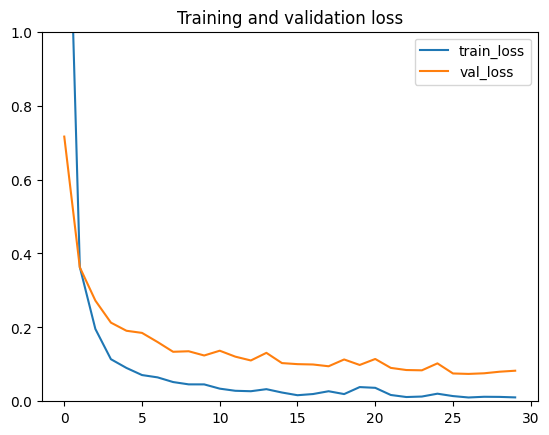

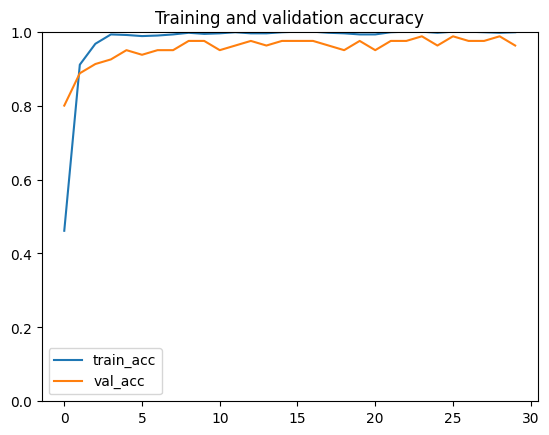

In [ ]:
## Accuracy poltlib
epochs = num_epochs
plt.figure()
plt.title('Training and validation loss')
plt.plot(np.arange(0, epochs), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, epochs), history.history["val_loss"], label="val_loss")
plt.ylim((0,1))
plt.legend()

plt.figure()
plt.title('Training and validation accuracy')
plt.plot(np.arange(0, epochs), history.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, epochs), history.history["val_accuracy"], label="val_acc")
plt.ylim((0,1))
plt.legend()

In [ ]:
# Create history JSON

history_ = pd.DataFrame(history.history)
with open(os.path.join(path_, "vgg16_results_", "history.json"), "w") as json_file:
    history_.to_json(json_file)

In [ ]:
# Load model

model = load_model('MY_PATH_OF_MODEL_H5')

## **Testing**

In [ ]:
# Inference with testgenerator

y_pred = model.predict(test_generator)
print(y_pred.shape)
y_pred_max = np.argmax(y_pred, 1)

print(y_pred[10])
print(y_pred_max[10])

12/12 [==============================] - 25s 1s/step
(192, 10)
[1.2894263e-08 2.5564202e-07 1.8691775e-09 6.7201888e-08 1.6417882e-08
 3.7923581e-08 2.3745632e-09 2.0236086e-09 1.5011116e-07 9.9999952e-01]
9


In [ ]:
# Crop the test dataset to the lenght of the predictions, which is automatically a multiple of the batch size.

X_test = [x for x,i in test_generator.list_IDs]
Y_test = [switch(str(x)) for x in X_test]

Y_test = Y_test[:len(y_pred_max)]

print(sklearn.metrics.classification_report(Y_test, y_pred_max))

print("accuracy:", accuracy_score(Y_test, y_pred_max))

              precision    recall  f1-score   support

           0       0.88      0.96      0.92        24
           1       1.00      1.00      1.00        23
           2       0.95      1.00      0.98        21
           3       1.00      1.00      1.00        19
           4       1.00      1.00      1.00        17
           5       1.00      1.00      1.00        20
           6       1.00      0.85      0.92        20
           7       1.00      1.00      1.00        16
           8       1.00      1.00      1.00        14
           9       1.00      1.00      1.00        18

    accuracy                           0.98       192
   macro avg       0.98      0.98      0.98       192
weighted avg       0.98      0.98      0.98       192

accuracy: 0.9791666666666666


In [ ]:
## show results

for i in range(num_results):
    fig, ax = plt.subplots()
    ax.imshow(load_img(os.path.join(base_path, X_test[i])))
    ax.set_title(img_ids[y_pred_max[i]])
    plt.show()


##Confusion Matrix

<Axes: >

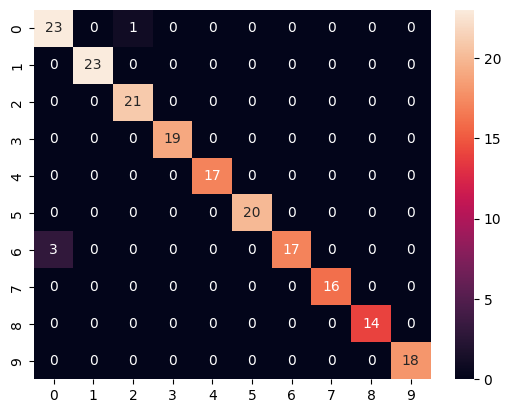

In [ ]:
conf = confusion_matrix(Y_test, y_pred_max)
sns.heatmap(conf, annot=True, fmt="d")

<Axes: >

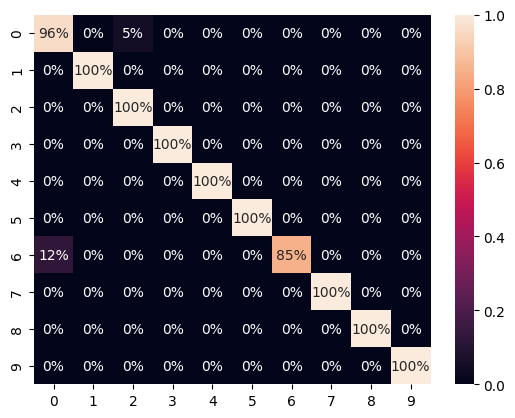

In [ ]:
cm = conf.astype('float') / conf.sum(axis=1)
sns.heatmap(cm, annot=True, fmt='.0%')

/content/gdrive/MyDrive/Colab Notebooks/progetto/DatasetNew/data/ic_CIE.front.15285.jpg
True Label: ic_CIE.front. Predicted Label: dl_I11.front. 

/content/gdrive/MyDrive/Colab Notebooks/progetto/DatasetNew/data/ic_TES.front.13227.jpg
True Label: ic_TES.front. Predicted Label: ic_CIE.front. 

/content/gdrive/MyDrive/Colab Notebooks/progetto/DatasetNew/data/ic_TES.front.13227.jpg
True Label: ic_TES.front. Predicted Label: ic_CIE.front. 

/content/gdrive/MyDrive/Colab Notebooks/progetto/DatasetNew/data/ic_TES.front.13227.jpg
True Label: ic_TES.front. Predicted Label: ic_CIE.front. 



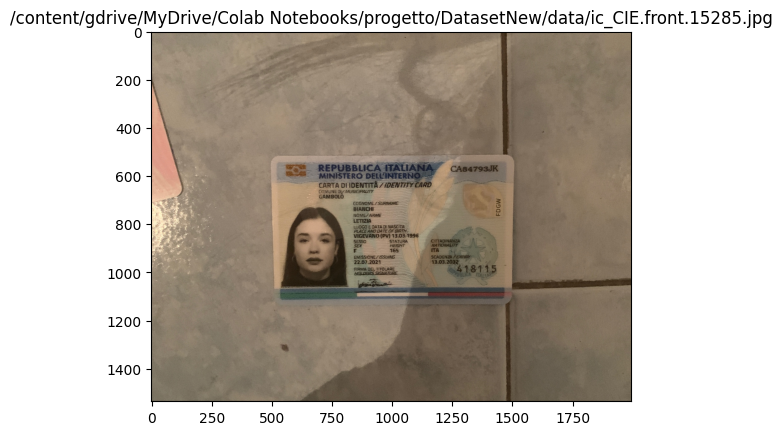

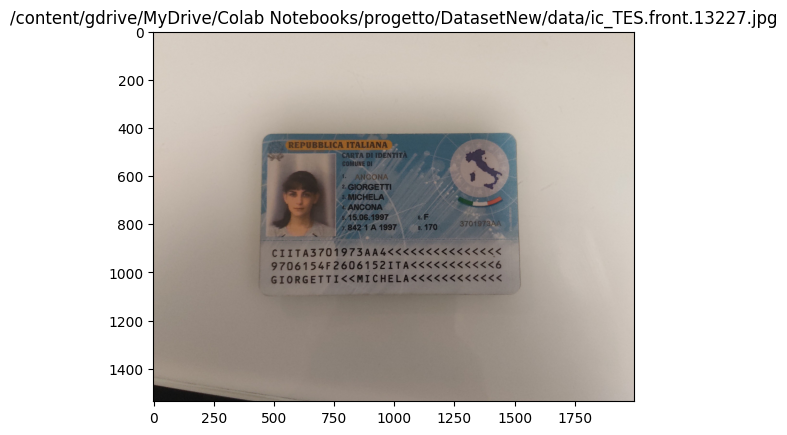

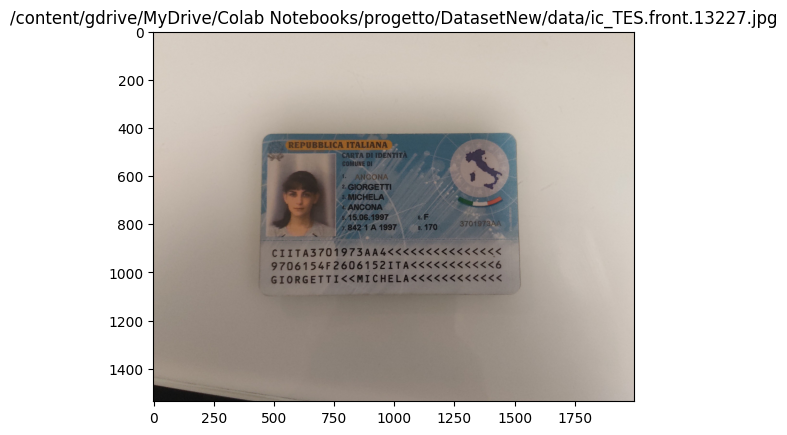

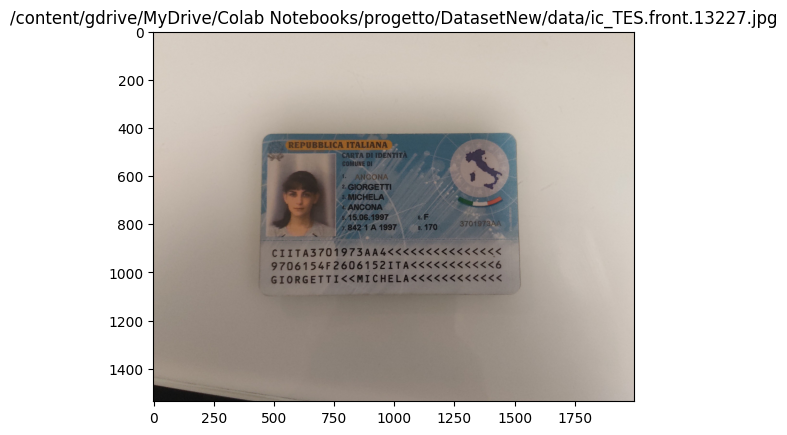

In [ ]:
# Find wrong predictions

array = []
for i in range(0,len(Y_test)):
  if Y_test[i] != y_pred_max[i]:
    array.append(i)

for i in array:
  fig, ax = plt.subplots()
  ax.imshow(load_img(os.path.join(base_path, X_test[i])))
  ax.set_title(X_test[i])
  print(X_test[i])
  print("True Label: " + img_ids[Y_test[i]],"Predicted Label: " + img_ids[y_pred_max[i]],"\n")

/content/gdrive/MyDrive/Colab Notebooks/progetto/DatasetNew/data/ic_TES.front.13227.jpg


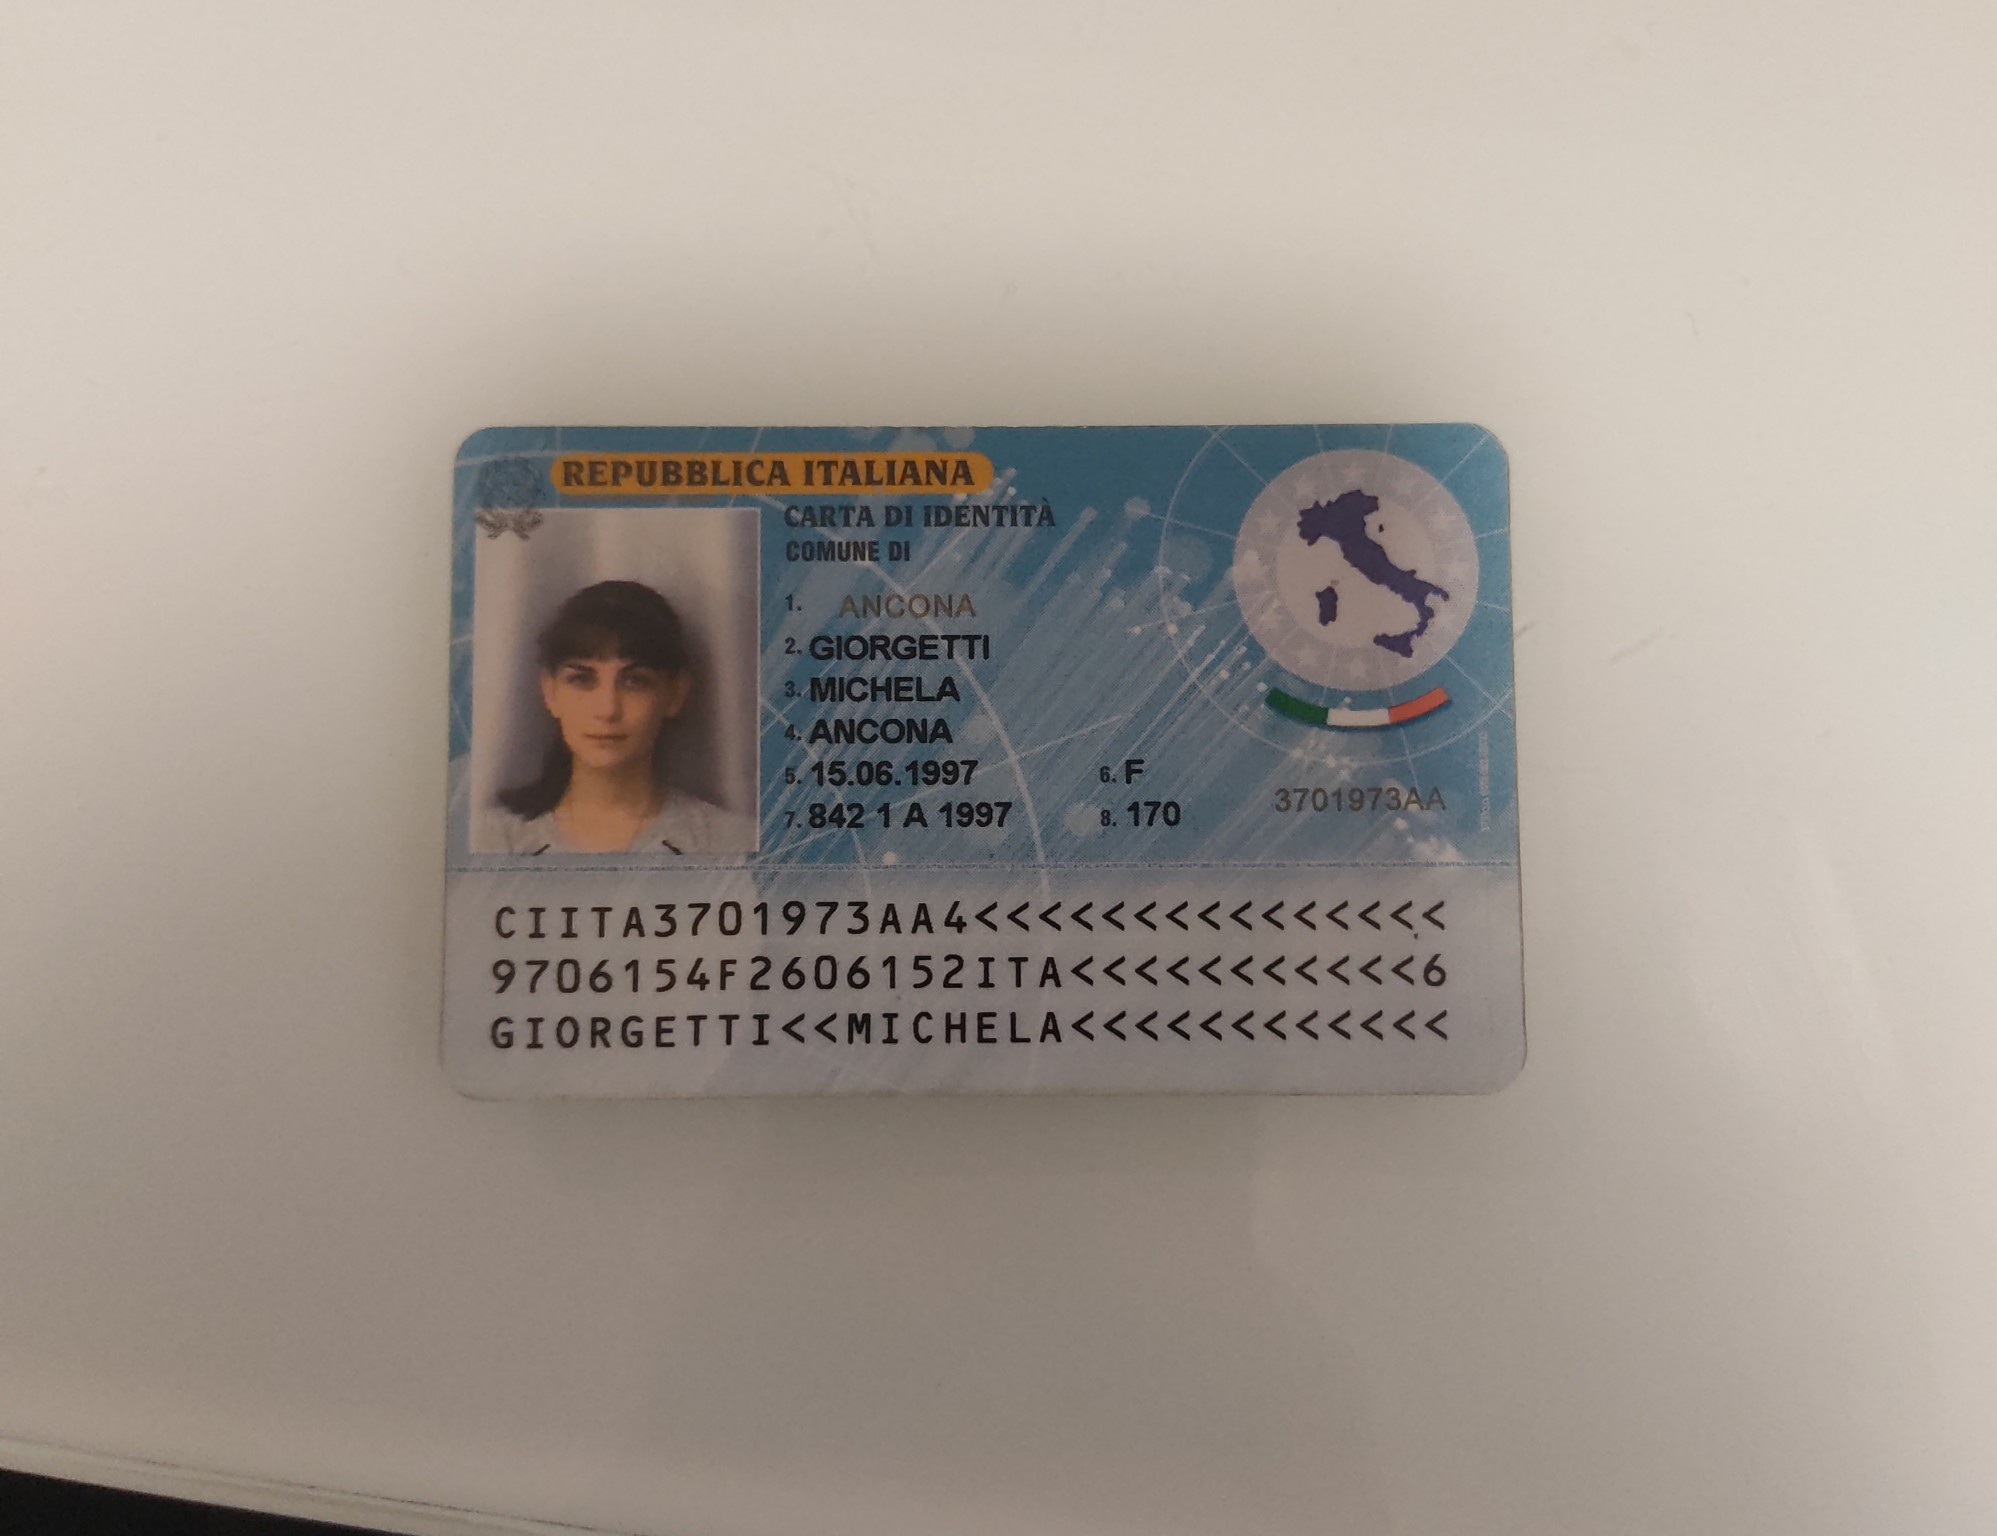

In [ ]:
# Load random image with wrong predictions

model_builder = model
last_conv_layer = model.layers[-7].name

random_im = random.randint(0,len(array)-1)
image_path = X_test[array[random_im]]
print(image_path)
display(Image(image_path))

In [ ]:
# Vectorize the given image to get a numpy array

def vectorize_image(img_path, size):

    img = image.load_img(img_path, target_size=size)
    array = image.img_to_array(img)
    array = np.expand_dims(array, axis=0) # Adding dimension to convert array into a batch of size (1,299,299,3)
    return array

In [ ]:
vectorized_image = preproc_vgg(vectorize_image(image_path, size=inp_dim))

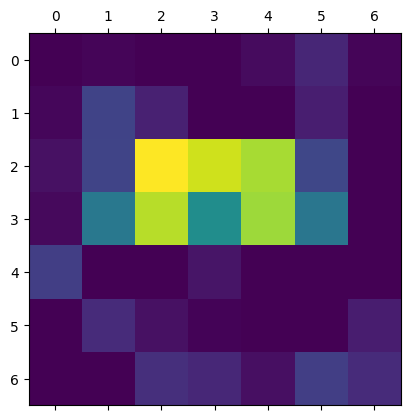

In [ ]:
# Function to visualize grad-cam heatmaps

def get_heatmap(vectorized_image, model, last_conv_layer, pred_index=None):

    gradient_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer).output, model.output]
    )

    # Gradient Computations
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = gradient_model(vectorized_image)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    grads = tape.gradient(class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap) # Normalize the heatmap
    return heatmap.numpy()

plt.matshow(get_heatmap(vectorized_image, model, last_conv_layer))
plt.show()

<ipython-input-26-a2dd2eb91851>:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = c_map.get_cmap("jet") # Colorizing heatmap


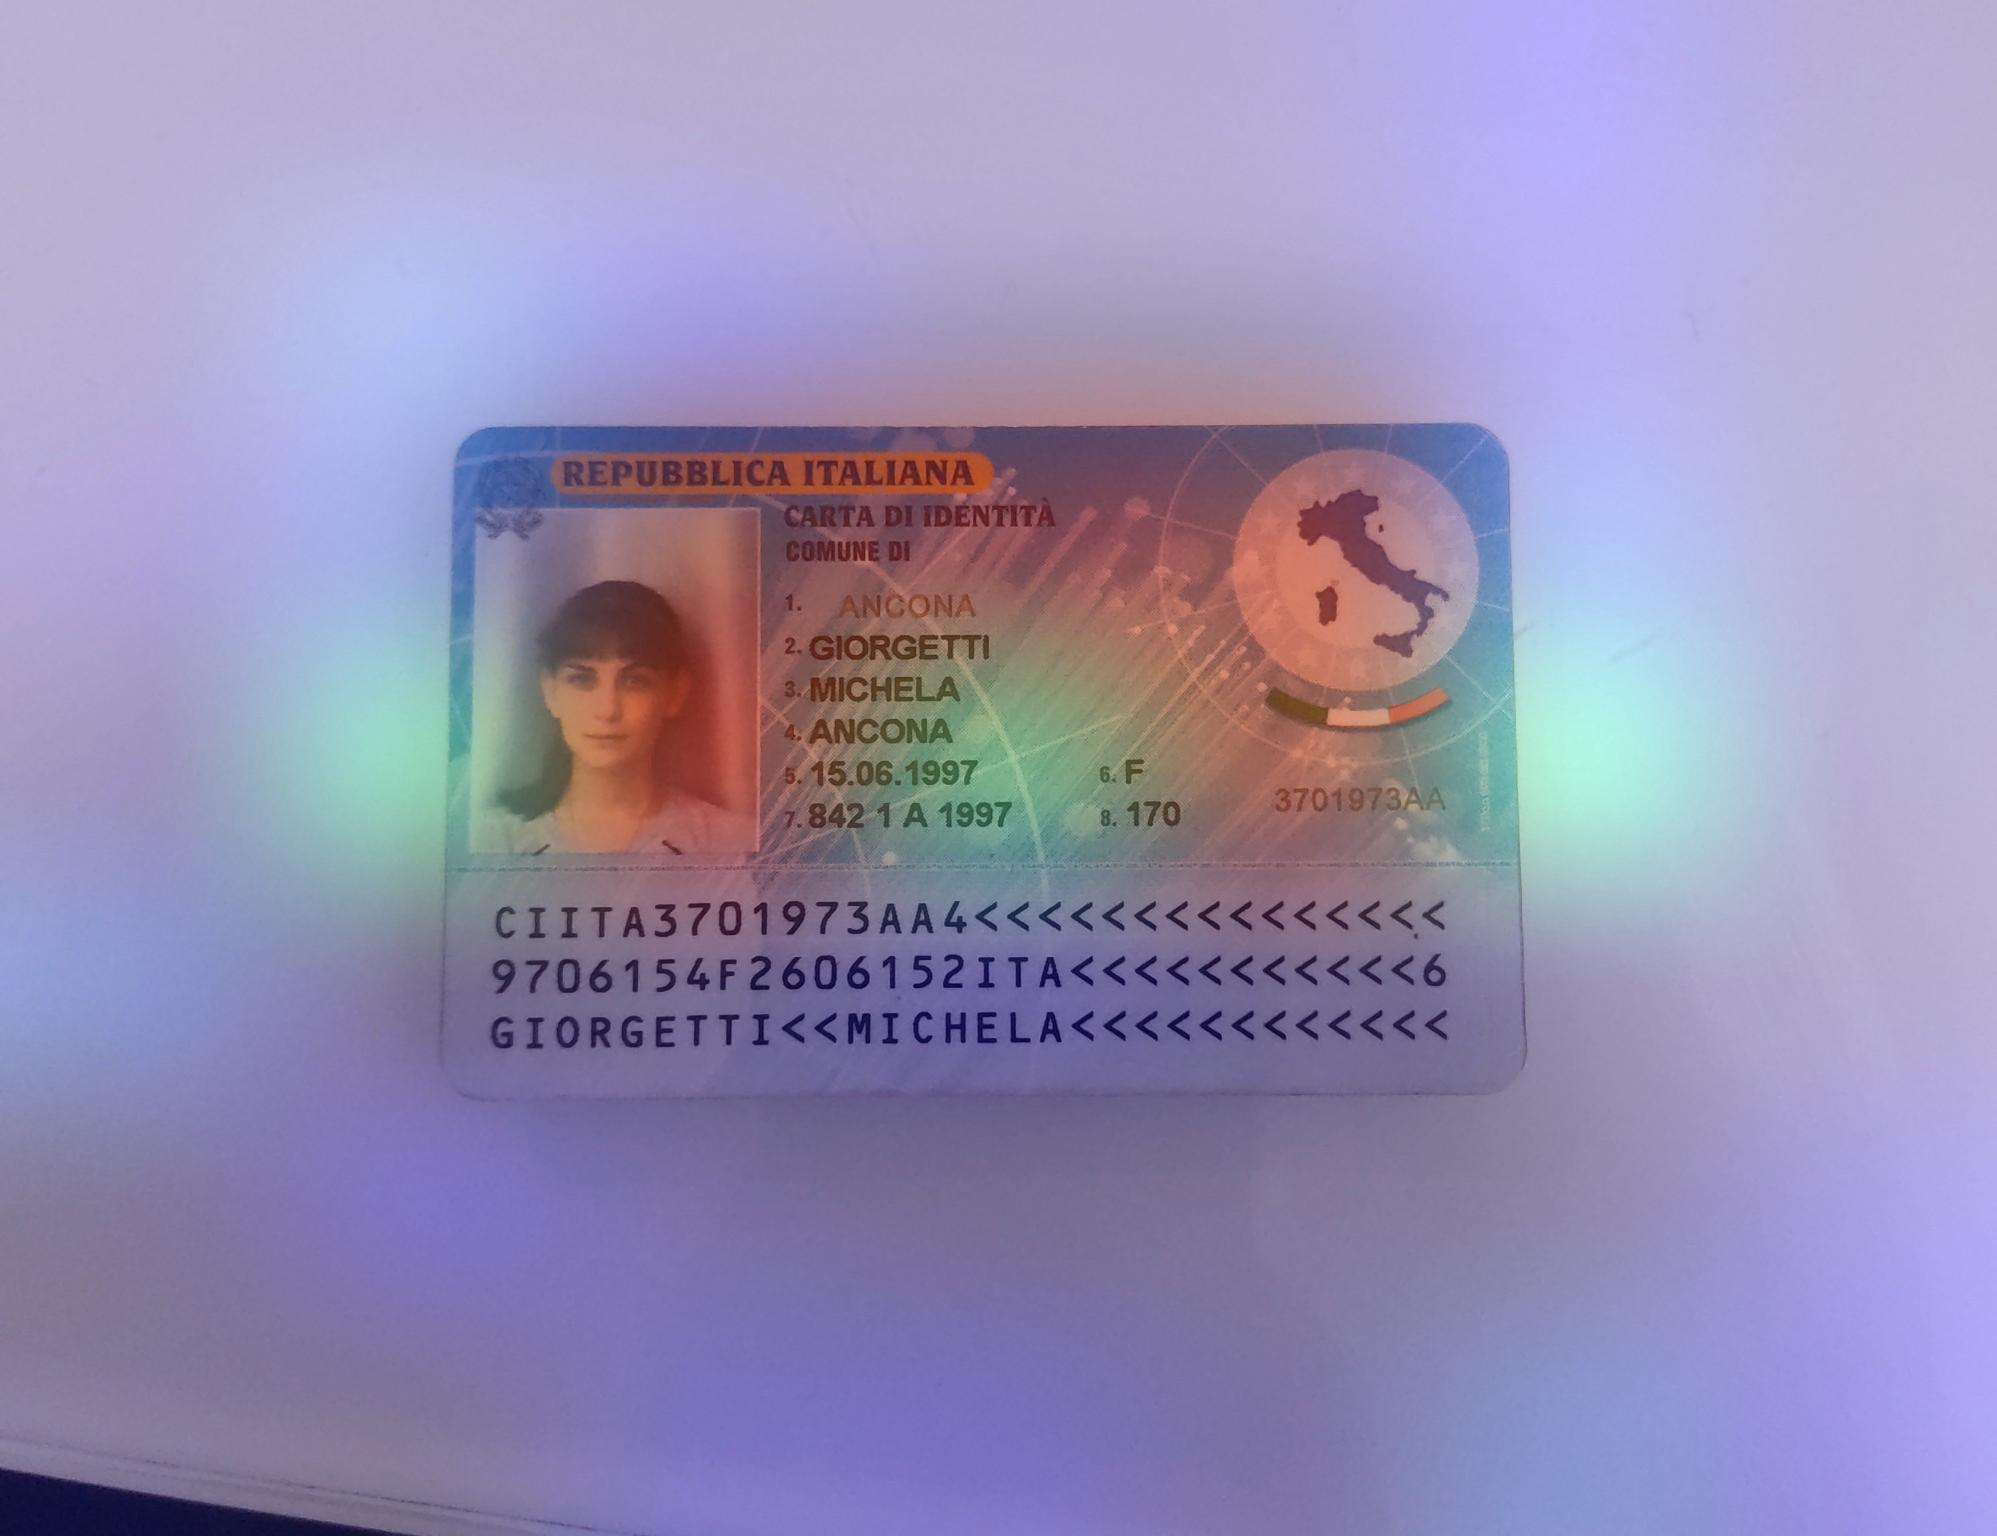

In [ ]:
# Superimpose Grad-CAM Heatmap on image
def superimpose_gradcam(img_path, heatmap, output_path="grad_cam_image.jpg", alpha=0.4):

    img = image.load_img(img_path)
    img = image.img_to_array(img)

    heatmap = np.uint8(255 * heatmap) # Back scaling to 0-255 from 0 - 1
    jet = c_map.get_cmap("jet") # Colorizing heatmap
    jet_colors = jet(np.arange(256))[:, :3] # Using RGB values
    jet_heatmap = jet_colors[heatmap]
    jet_heatmap = image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = image.img_to_array(jet_heatmap)


    superimposed_img = jet_heatmap * alpha + img # Superimposing the heatmap on original image
    superimposed_img = image.array_to_img(superimposed_img)

    superimposed_img.save(output_path) # Saving the superimposed image
    display(Image(output_path)) # Displaying Grad-CAM Superimposed Image

superimpose_gradcam(image_path, get_heatmap(vectorized_image, model, last_conv_layer))